# Color engineering for special images

## How to improve color encoding of unnatural images

**Not all images that are colorful, should be colorful.** Or in other words, not all images that use RGB (red, green, blue) encoding should be using exactly these colors! In this article we will explore how different ways of feature engineering - i.e. spreading the original color values out - can help with improving the classification performance of a convolutional neural network.

Note, there are numerous ways of how you can change and adapt the color encoding of RGB images (e.g. transforming RGB to HSV, LAB or XYZ values; `scikit-image` offers [many great routines](https://scikit-image.org/docs/stable/auto_examples/#manipulating-exposure-and-color-channels) to do this) - however this article is not about that. It's much more about thinking about what the data tries to capture and how to exploit that.

To better highlight what I mean by that, let's take a look at the following three datasets (each image shows 100s of individual images from that dataset):

![MedMNIST](medmnist.png)

*These three datasets are part of the [MedMNIST](https://medmnist.com) dataset - images are taken from the [corresponding paper](https://arxiv.org/pdf/2010.14925.pdf).*

What these datasets have in common is the fact that the individual images from a given dataset very much stick to a specific color range. While there are fluctuations in pink or red tones, for most of these images it is more important how the contrast differs between images than what the actual RGB color value represents.

This offers us a unique opportunity for feature engineering. Instead of sticking with the original RGB color values, we can investigate if an adaptation of the dataset specific color space can help and improve our data science investigations.

# The data set

To explore this topic, let's use the augmented bloodcell dataset (see original [paper](https://www.sciencedirect.com/science/article/pii/S2352340920303681)) from [MedMNIST](https://medmnist.com). This dataset contains roughly 17'000 individual images from 10 different blood cell types.

![blood_cell](blood_cell.jpg)

*Image is taken from the original [paper](https://www.sciencedirect.com/science/article/pii/S2352340920303681) and depicts the ten types of blood cell types that conform the dataset.*

In [2]:
# Download dataset
!wget https://zenodo.org/record/5208230/files/bloodmnist.npz

<IPython.core.display.Javascript object>

In [3]:
# Load packages
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px

import seaborn as sns

sns.set_context("talk")
%config InlineBackend.figure_format = 'retina'

<IPython.core.display.Javascript object>

In [4]:
# Load data set
data = np.load("bloodmnist.npz")
X_tr = data["train_images"].astype("float32") / 255
X_va = data["val_images"].astype("float32") / 255
X_te = data["test_images"].astype("float32") / 255
y_tr = data["train_labels"]
y_va = data["val_labels"]
y_te = data["test_labels"]

labels = ["basophils", "eosinophils", "erythroblasts",
          "granulocytes_immature", "lymphocytes",
          "monocytes", "neutrophils", "platelets"]

labels_tr = np.array([labels[j] for j in y_tr.ravel()])
labels_va = np.array([labels[j] for j in y_va.ravel()])
labels_te = np.array([labels[j] for j in y_te.ravel()])

<IPython.core.display.Javascript object>

So let's take a look at a few images from this dataset!

In [5]:
def plot_dataset(X):
    """Helper function to visualize first few images of a dataset."""
    fig, axes = plt.subplots(12, 12, figsize=(15.5, 16))
    for i, ax in enumerate(axes.flatten()):
        if X.shape[-1] == 1:
            ax.imshow(np.squeeze(X[i]), cmap="gray")
        else:
            ax.imshow(X[i])
        ax.axis("off")
        ax.set_aspect("equal")
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

<IPython.core.display.Javascript object>

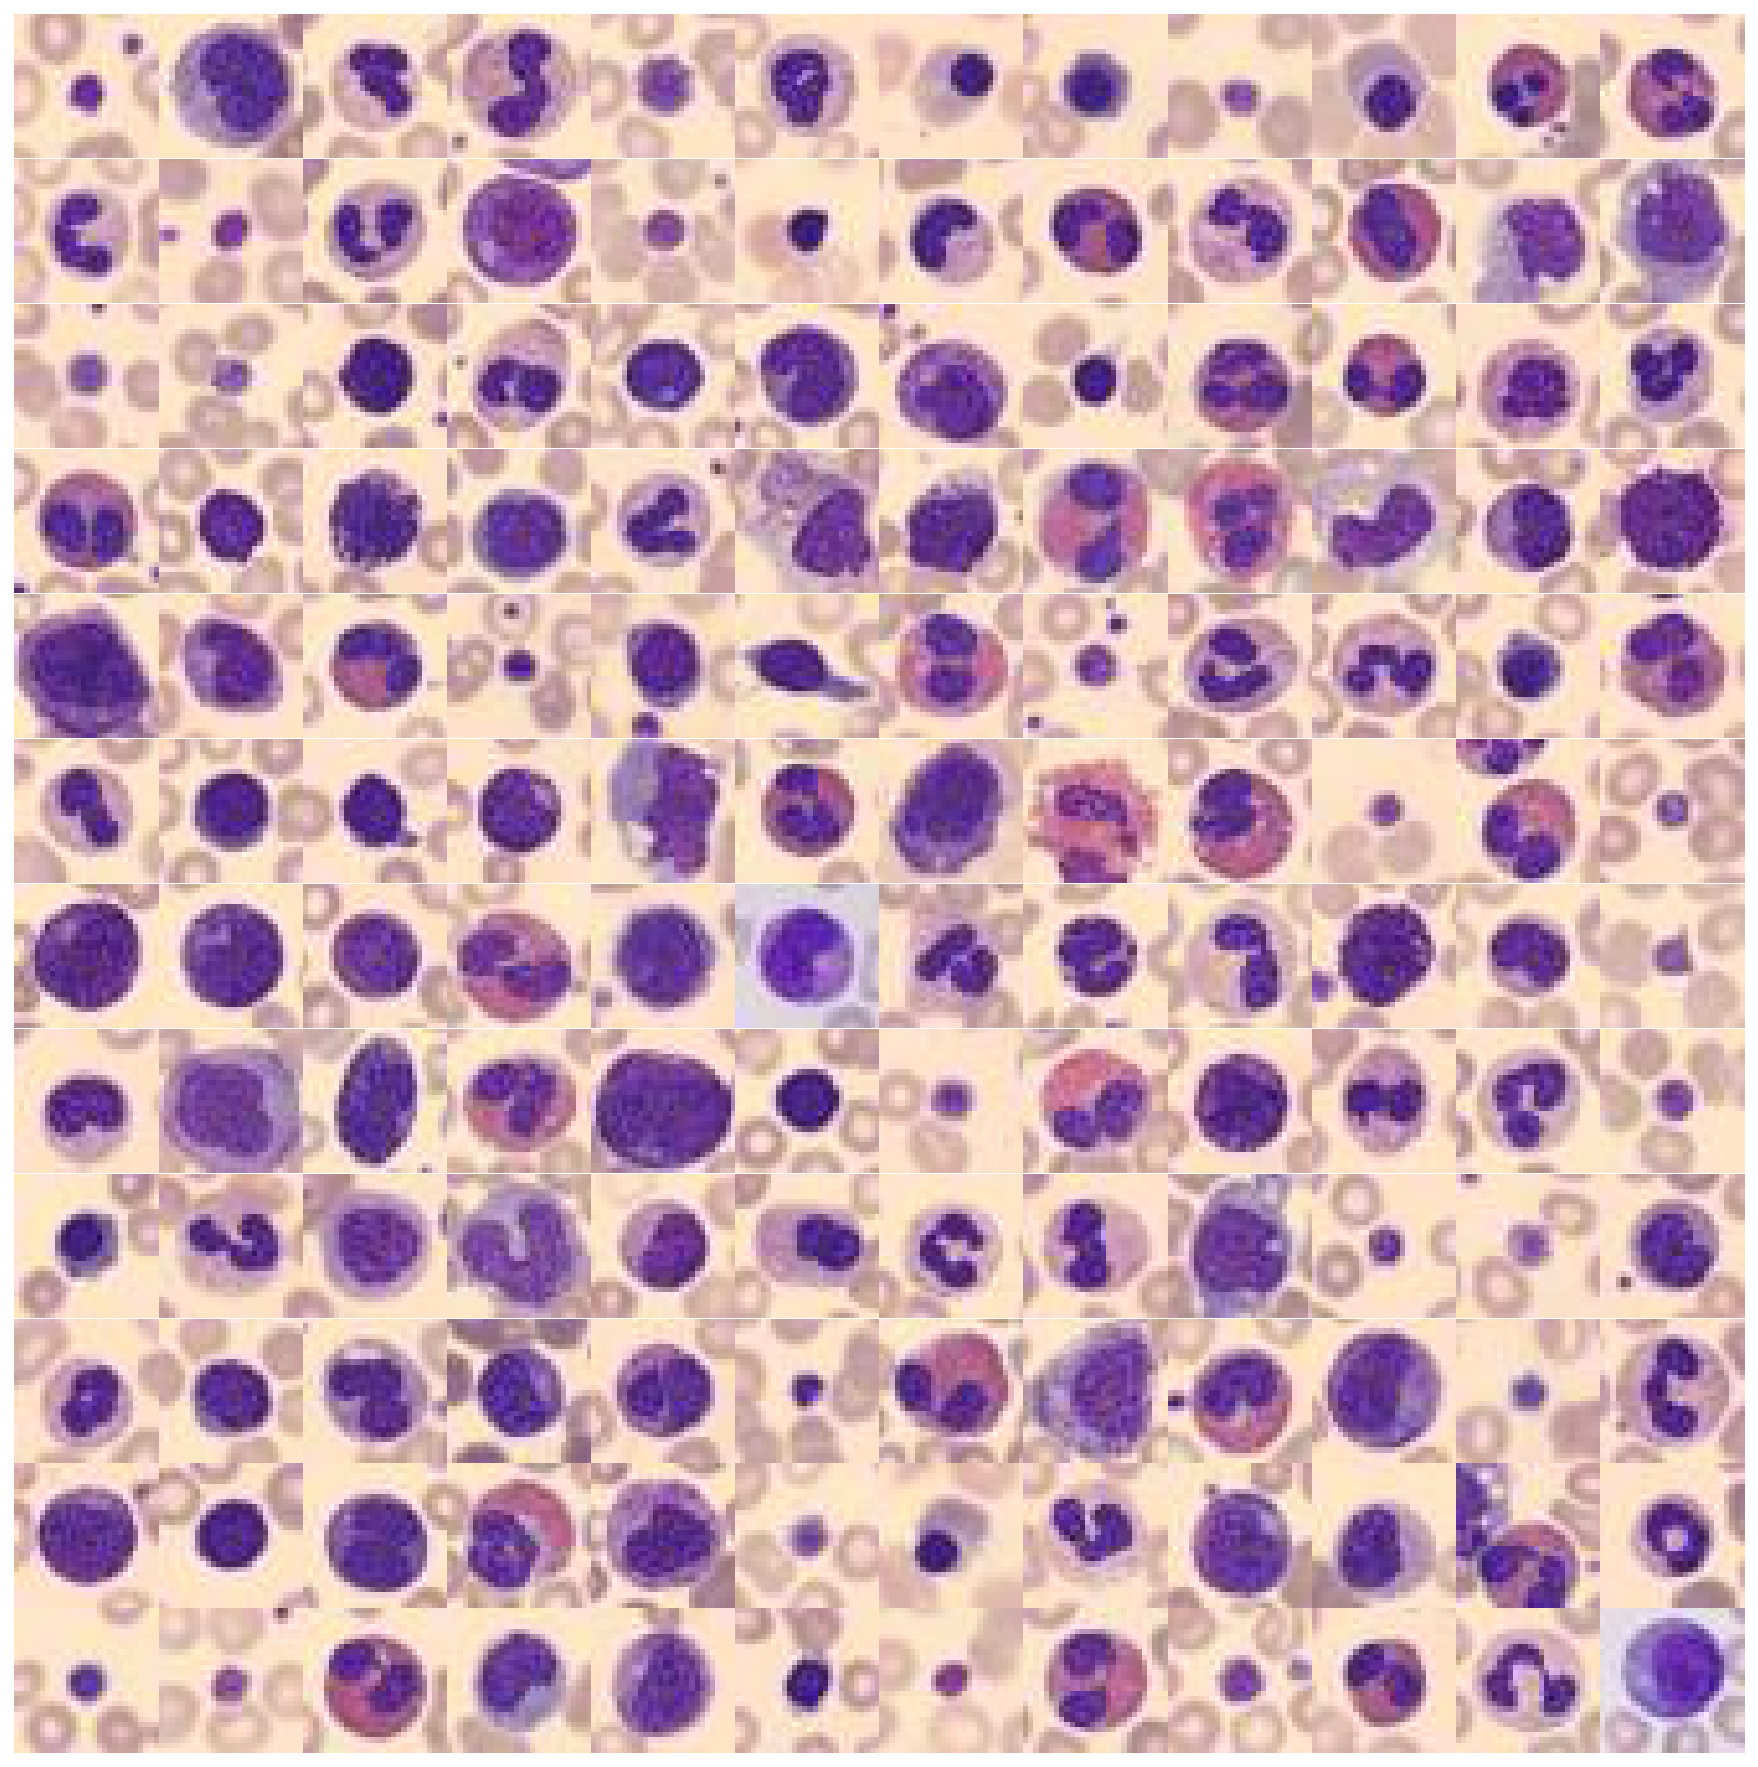

<IPython.core.display.Javascript object>

In [6]:
# Plot dataset
plot_dataset(X_tr)

**What you can see is the following:** The background color, as well as the main target object color is in most of the cases the same (but not always)! To better understand why this offers us an opportunity for color value engineering, let's take a look at the RGB color space that these images occupy.

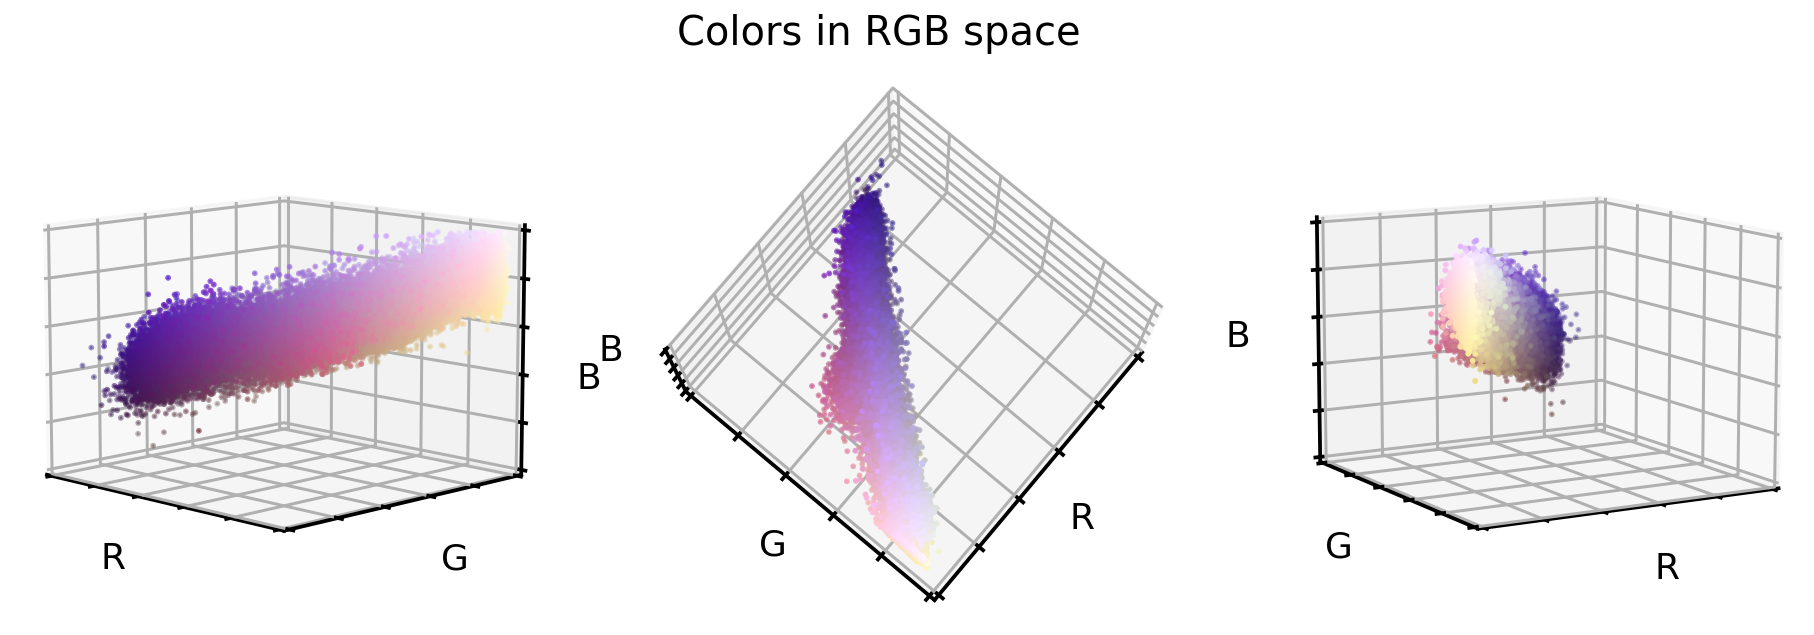

<IPython.core.display.Javascript object>

In [7]:
# Extract a few RGB color values
X_colors = X_tr.reshape(-1, 3)[::100]

# Plot color values in 3D space
fig = plt.figure(figsize=(16, 5))

# Loop through 3 different views
for i, view in enumerate([[-45, 10], [40, 80], [60, 10]]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(X_colors[:, 0], X_colors[:, 1], X_colors[:, 2], facecolors=X_colors, s=2)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(azim=view[0], elev=view[1], vertical_axis="z")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
plt.suptitle("Colors in RGB space", fontsize=20)
plt.show()

These are three different views on the same RGB color space of the original dataset. What you can see is that this dataset only covers a small section of the full cube, i.e. all 16'777'216 possible color values. This offers us now three unique opportunities:

1. We could **reduce the image complexity** by transforming the RGB colors to **grayscale images**.
2. We could **realign and stretch the color values** so that the RGB values better fill the RGB color space.
3. We could **reorient the color values** so that the three cube axis stretch into the direction of highest variance. This is best done via a PCA approach.

**Note:** There are of course multiple other ways how we could manipulate our color values, but for this article, we will go with the three mentioned here.

# Data set augmentation

## 1. Grayscale transformation

First things first, let's transform the RGB images to grayscale images (i.e. go from a 3D to a 1D data set). Note, grayscale images are not just a simple averaging of RGB, but a slight imbalanced weighting thereof. We will use `scikit-image`'s `rgb2gray` to perform this transformation. Furthermore, we will stretch the grayscale values to fully cover the 0 to 255 value range of images.

In [8]:
# Install scikit-image if not already done
!pip install -U scikit-image

<IPython.core.display.Javascript object>

In [9]:
from skimage.color import rgb2gray

# Create grayscale images
X_tr_gray = rgb2gray(X_tr)[..., None]
X_va_gray = rgb2gray(X_va)[..., None]
X_te_gray = rgb2gray(X_te)[..., None]

# Stretch color range to training min, max
gmin_tr = X_tr_gray.min()
X_tr_gray -= gmin_tr
X_va_gray -= gmin_tr
X_te_gray -= gmin_tr

gmax_tr = X_tr_gray.max()
X_tr_gray /= gmax_tr
X_va_gray /= gmax_tr
X_te_gray /= gmax_tr

X_va_gray = np.clip(X_va_gray, 0, 1)
X_te_gray = np.clip(X_te_gray, 0, 1)

<IPython.core.display.Javascript object>

Let's take a look at how these grayscale color values are positioned in the previous RGB color space.

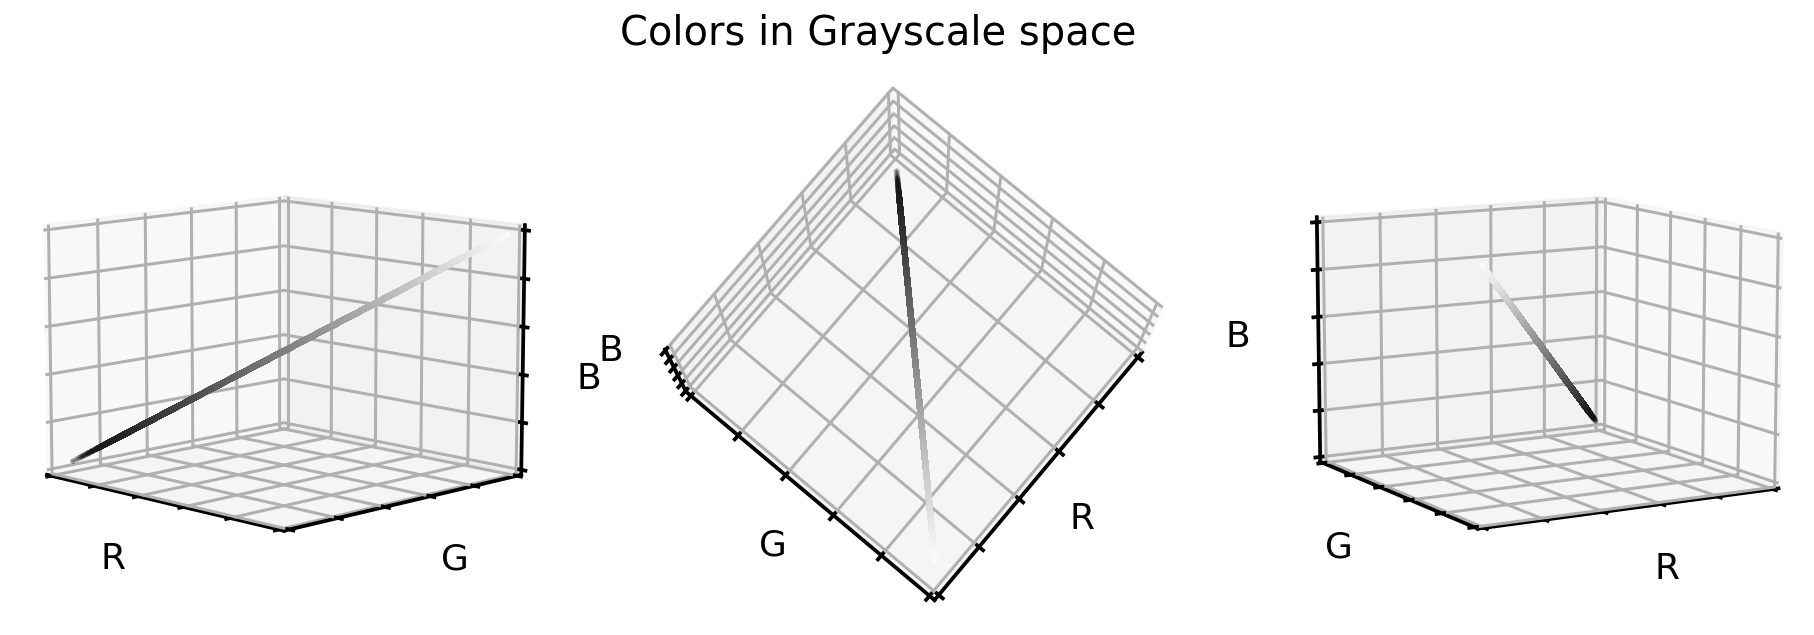

<IPython.core.display.Javascript object>

In [10]:
# Put 1D values into 3D space
X_tr_show = np.concatenate([X_tr_gray, X_tr_gray, X_tr_gray], axis=-1)

# Extract a few grayscale color values
X_grays = X_tr_show.reshape(-1, 3)[::100]

# Plot color values in 3D space
fig = plt.figure(figsize=(16, 5))

# Loop through 3 different views
for i, view in enumerate([[-45, 10], [40, 80], [60, 10]]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(X_grays[:, 0], X_grays[:, 1], X_grays[:, 2], facecolors=X_grays, s=2)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(azim=view[0], elev=view[1], vertical_axis="z")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
plt.suptitle("Colors in Grayscale space", fontsize=20)
plt.show()

Not surprising, the grayscale color values lay exactly on the cube diagonal. As such we were able to reduce our three dimensional dataset to one dimension. Let's take a look at how the cell images look like in grayscale format.

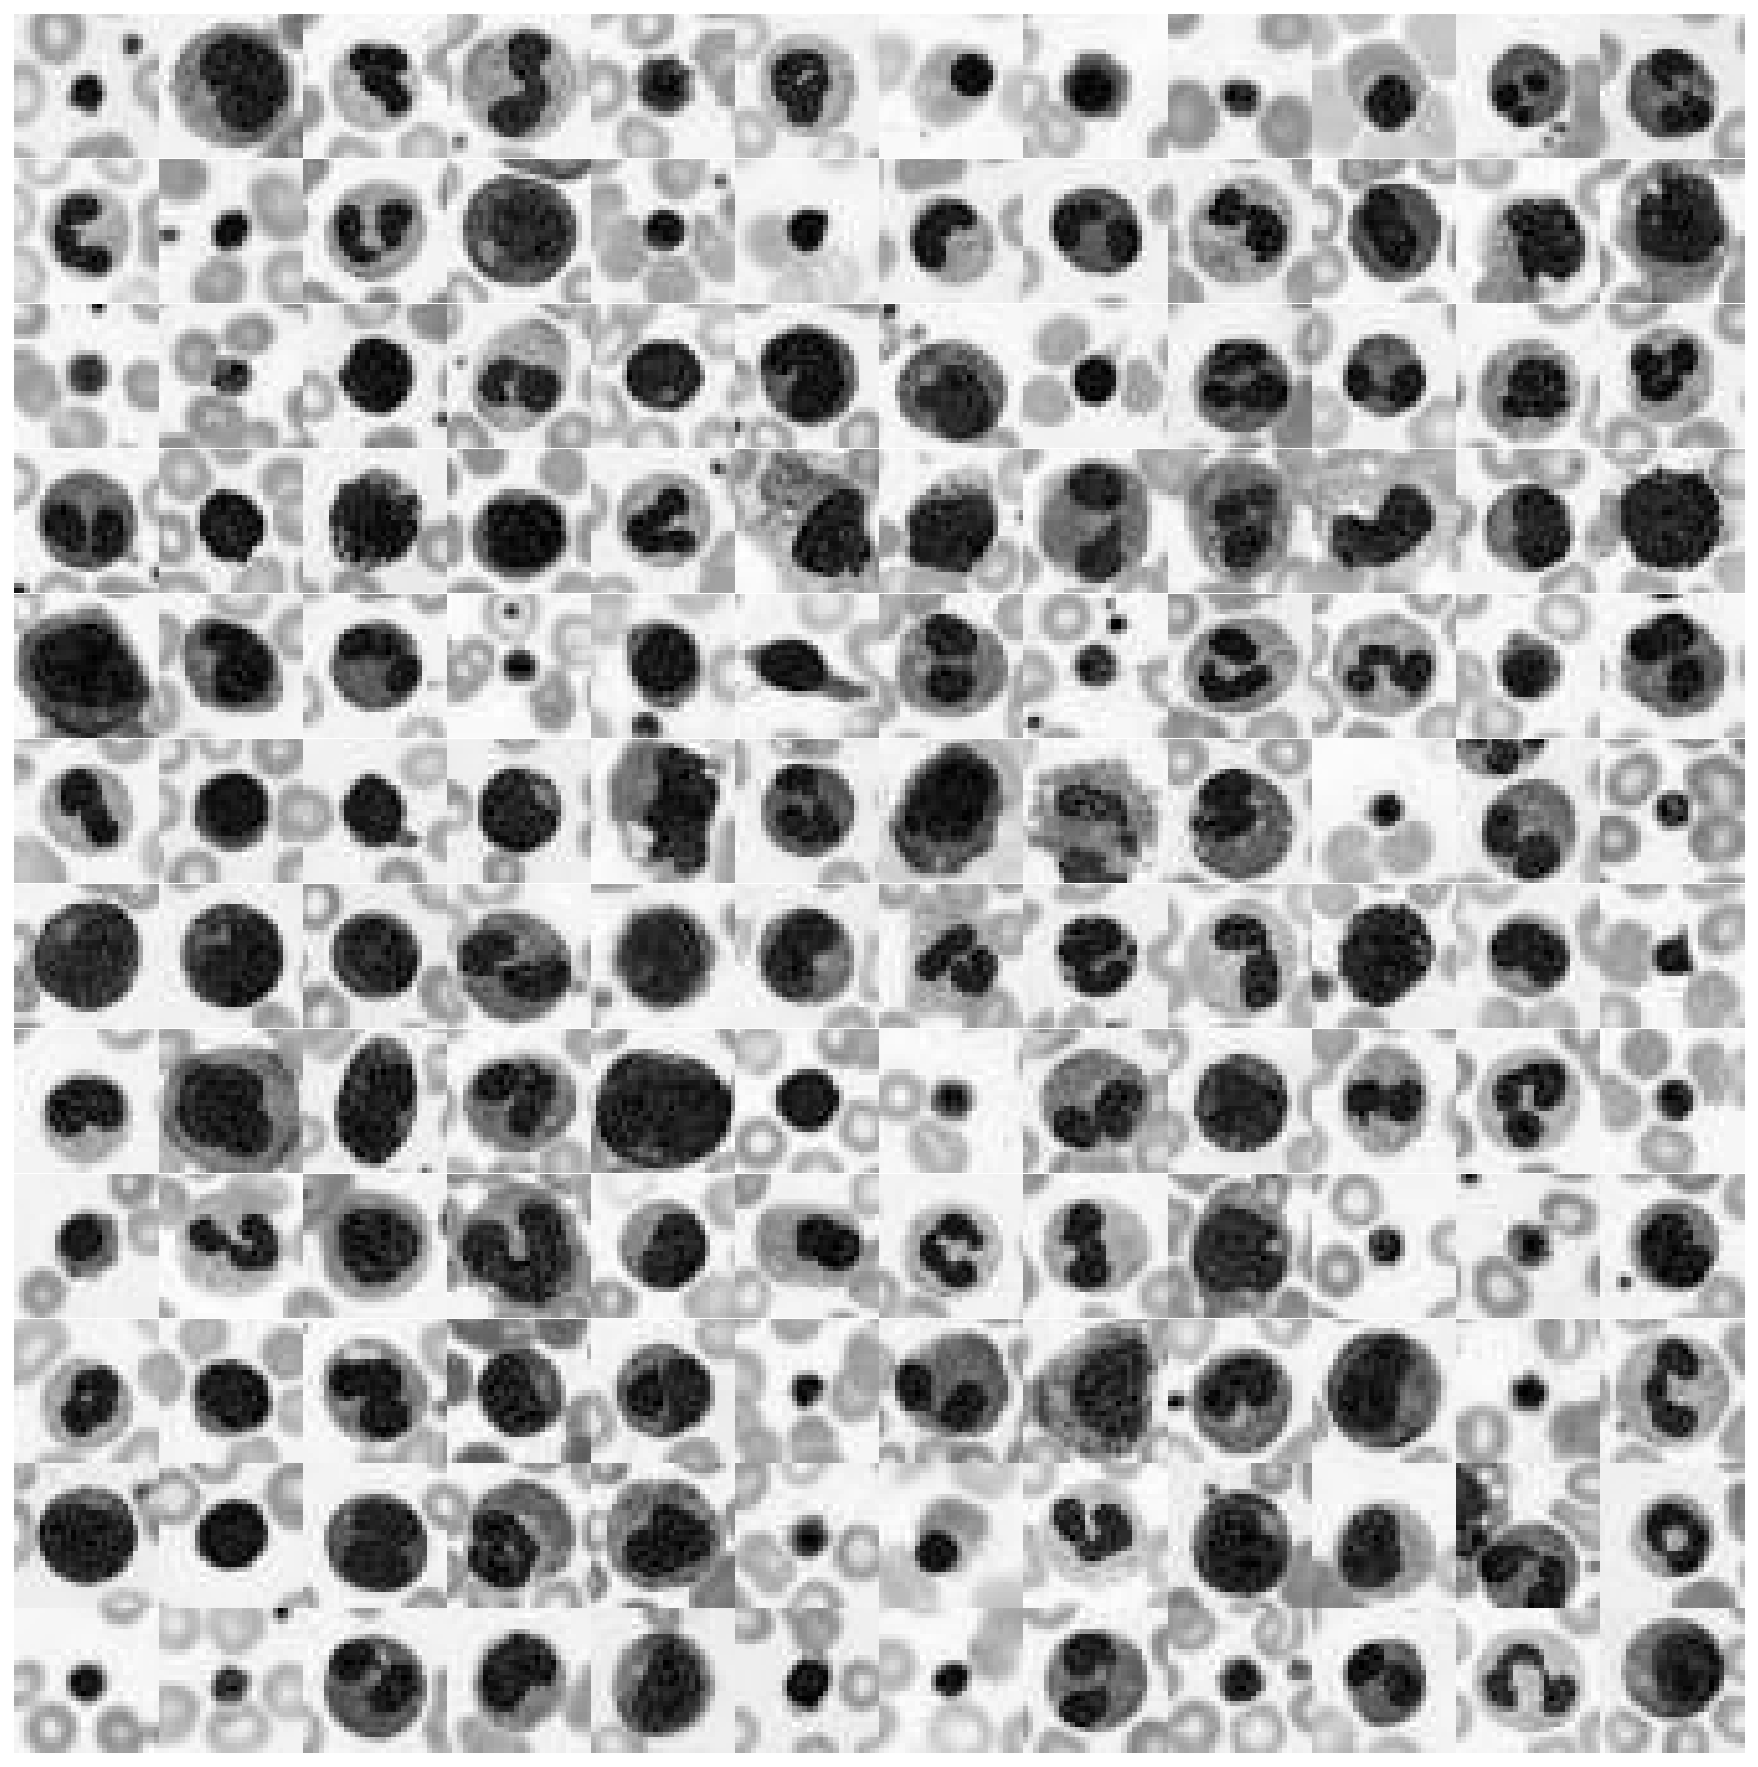

<IPython.core.display.Javascript object>

In [11]:
# Plot dataset
plot_dataset(X_tr_gray)

## 2. Color realigning and stretching

In the first RGB cube plot we saw that the color values of this dataset occupies only a part of the full cube. However, when comparing that point cloud to the black-white diagonal line from the second RGB cube plot, we can see that the original colors are off axis and slightly bend.

To better illustrate what we mean by that, let's try to find the equally spaced 'cloud centroids' (or center of masses) that support this point cloud.

In [12]:
# Get RGB color values
X_colors = X_tr.reshape(-1, 3)

# Get distance of all color values to black (0,0,0)
dist_origin = np.linalg.norm(X_colors, axis=-1)

# Find index of 0.1% smallest entry
perc_sorted = np.argsort(np.abs(dist_origin - np.percentile(dist_origin, 0.1)))

# Find centroid of lowest 0.1% RGBs
centroid_low = np.mean(X_colors[perc_sorted][: len(X_colors) // 1000], axis=0)

# Order all RGB values with regards to distance to low centroid
order_idx = np.argsort(np.linalg.norm(X_colors - centroid_low, axis=-1))

# According to this order, divide all RGB values into N equal sized chunks
nth = 256
splits = np.array_split(np.arange(len(order_idx)), nth, axis=0)

# Compute centroids, i.e. RGB mean values of each segment
centroids = np.array([np.median(X_colors[order_idx][s], axis=0) for s in tqdm(splits)])

# Only keep centroids that are spaced enough
new_centers = [centroids[0]]
for i in range(len(centroids)):
    if np.linalg.norm(new_centers[-1] - centroids[i]) > 0.03:
        new_centers.append(centroids[i])
new_centers = np.array(new_centers)

  0%|          | 0/256 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

Once we have these centers, as before, let's visualize them in the RGB color cube. And to support our point, let's also add the grayscale diagonal to this plot.

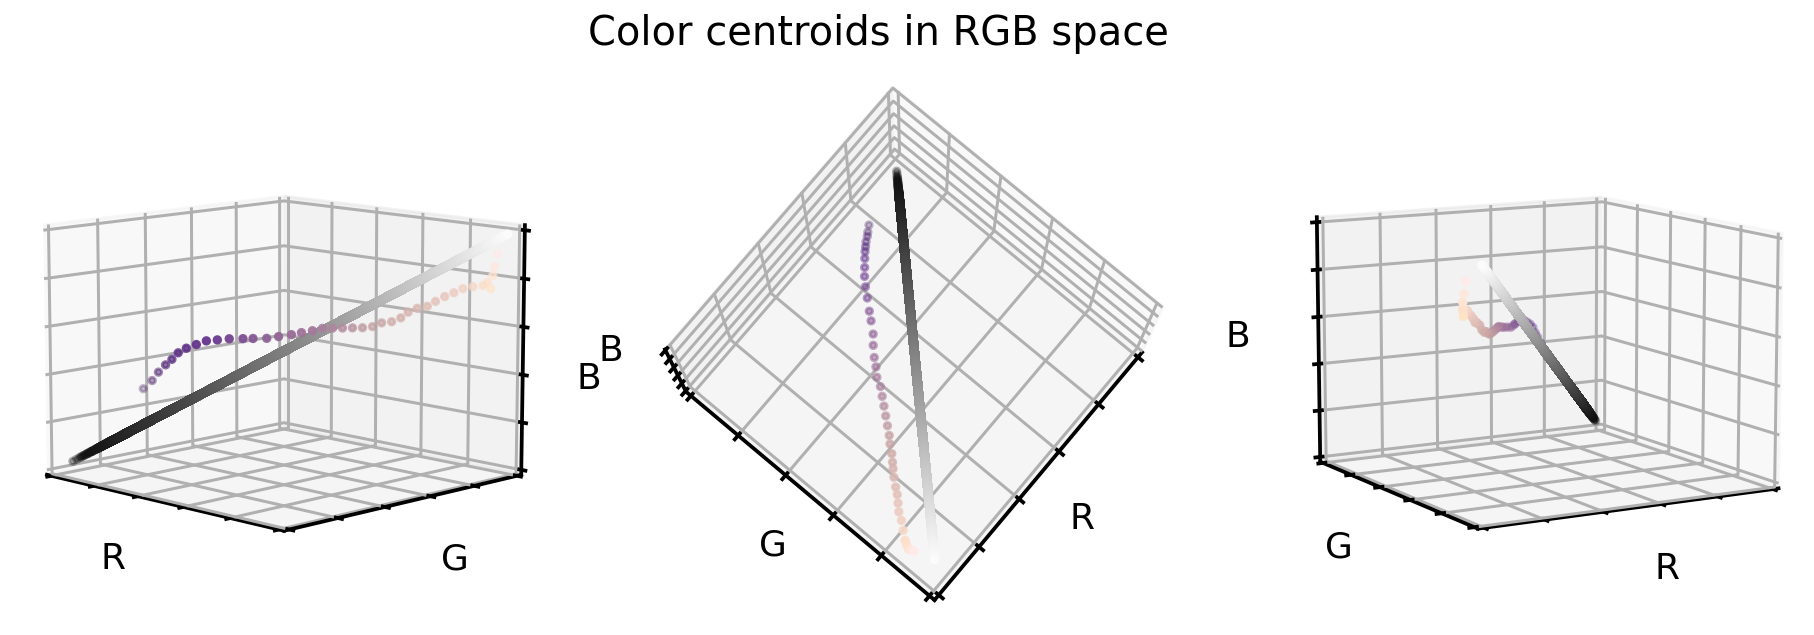

<IPython.core.display.Javascript object>

In [13]:
# Plot centroids in 3D space
fig = plt.figure(figsize=(16, 5))

# Loop through 3 different views
for i, view in enumerate([[-45, 10], [40, 80], [60, 10]]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(X_grays[:, 0], X_grays[:, 1], X_grays[:, 2], facecolors=X_grays, s=10)
    ax.scatter(
        new_centers[:, 0],
        new_centers[:, 1],
        new_centers[:, 2],
        facecolors=new_centers,
        s=10,
    )
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    ax.view_init(azim=view[0], elev=view[1], vertical_axis="z")
plt.suptitle("Color centroids in RGB space", fontsize=20)
plt.show()

So how can we use these two information (the cloud centroids and the gray scale diagonal) to **realign and stretch** our original dataset? Well, one way to do so is the following:

1. For each color value in the original dataset we compute the distance vector to the closest cloud centroid.
2. Then we add this distance vector to the grayscale diagonal (i.e. realign the cloud centroids).
3. And as last step we stretch and clip color values to make sure that 99.9% all values are in the desired color range.

In [14]:
# Create grayscale diagonal centroids (equal numbers to cloud centroids)
steps = np.linspace(0.2, 0.8, len(new_centers))

# Realign and stretch images
X_tr_stretch = np.array(
    [x - new_centers[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     + steps[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     for x in tqdm(X_tr.reshape(-1, 3))])
X_va_stretch = np.array(
    [x - new_centers[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     + steps[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     for x in tqdm(X_va.reshape(-1, 3))])
X_te_stretch = np.array(
    [x - new_centers[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     + steps[np.argmin(np.linalg.norm(x - new_centers, axis=1))]
     for x in tqdm(X_te.reshape(-1, 3))])

# Stretch and clip data
xmin_tr = np.percentile(X_tr_stretch, 0.05, axis=0)
X_tr_stretch -= xmin_tr
X_va_stretch -= xmin_tr
X_te_stretch -= xmin_tr
xmax_tr = np.percentile(X_tr_stretch, 99.95, axis=0)
X_tr_stretch /= xmax_tr
X_va_stretch /= xmax_tr
X_te_stretch /= xmax_tr
X_tr_stretch = np.clip(X_tr_stretch, 0, 1)
X_va_stretch = np.clip(X_va_stretch, 0, 1)
X_te_stretch = np.clip(X_te_stretch, 0, 1)

  0%|          | 0/9375856 [00:00<?, ?it/s]

  0%|          | 0/1342208 [00:00<?, ?it/s]

  0%|          | 0/2682064 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

So, what do the original RGB color values look like once they were realigned and stretched?

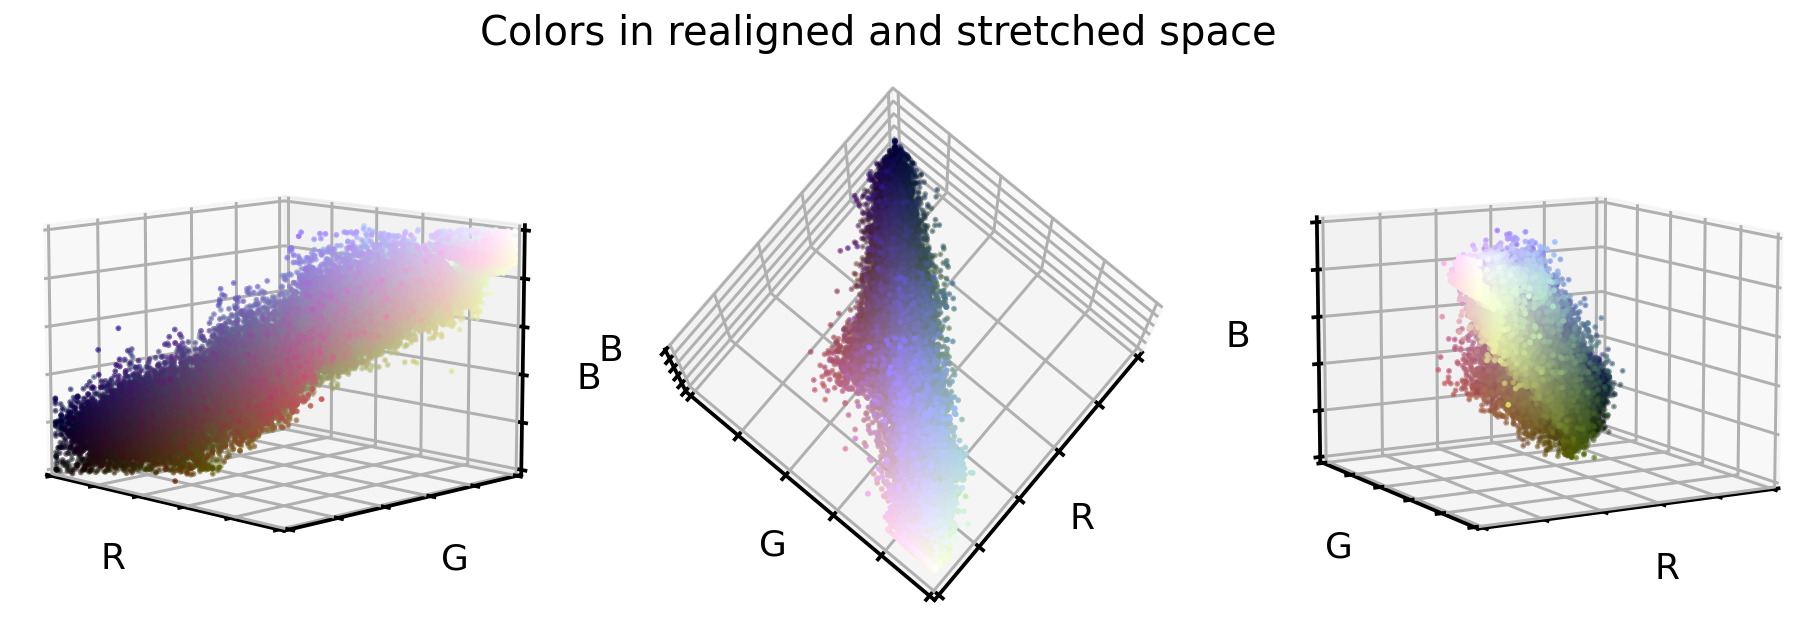

<IPython.core.display.Javascript object>

In [15]:
# Plot color values in 3D space
fig = plt.figure(figsize=(16, 5))

stretch_colors = X_tr_stretch[::100]

# Loop through 3 different views
for i, view in enumerate([[-45, 10], [40, 80], [60, 10]]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(
        stretch_colors[:, 0],
        stretch_colors[:, 1],
        stretch_colors[:, 2],
        facecolors=stretch_colors,
        s=2)
    ax.set_xlabel("R")
    ax.set_ylabel("G")
    ax.set_zlabel("B")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(azim=view[0], elev=view[1], vertical_axis="z")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
plt.suptitle("Colors in realigned and stretched space", fontsize=20)
plt.show()

That looks already very promising. The point cloud is much better aligned to the cube diagonal and it seems the point cloud is a bit more stretched into all directions. And what do the cellular images look like in this new color encoding?

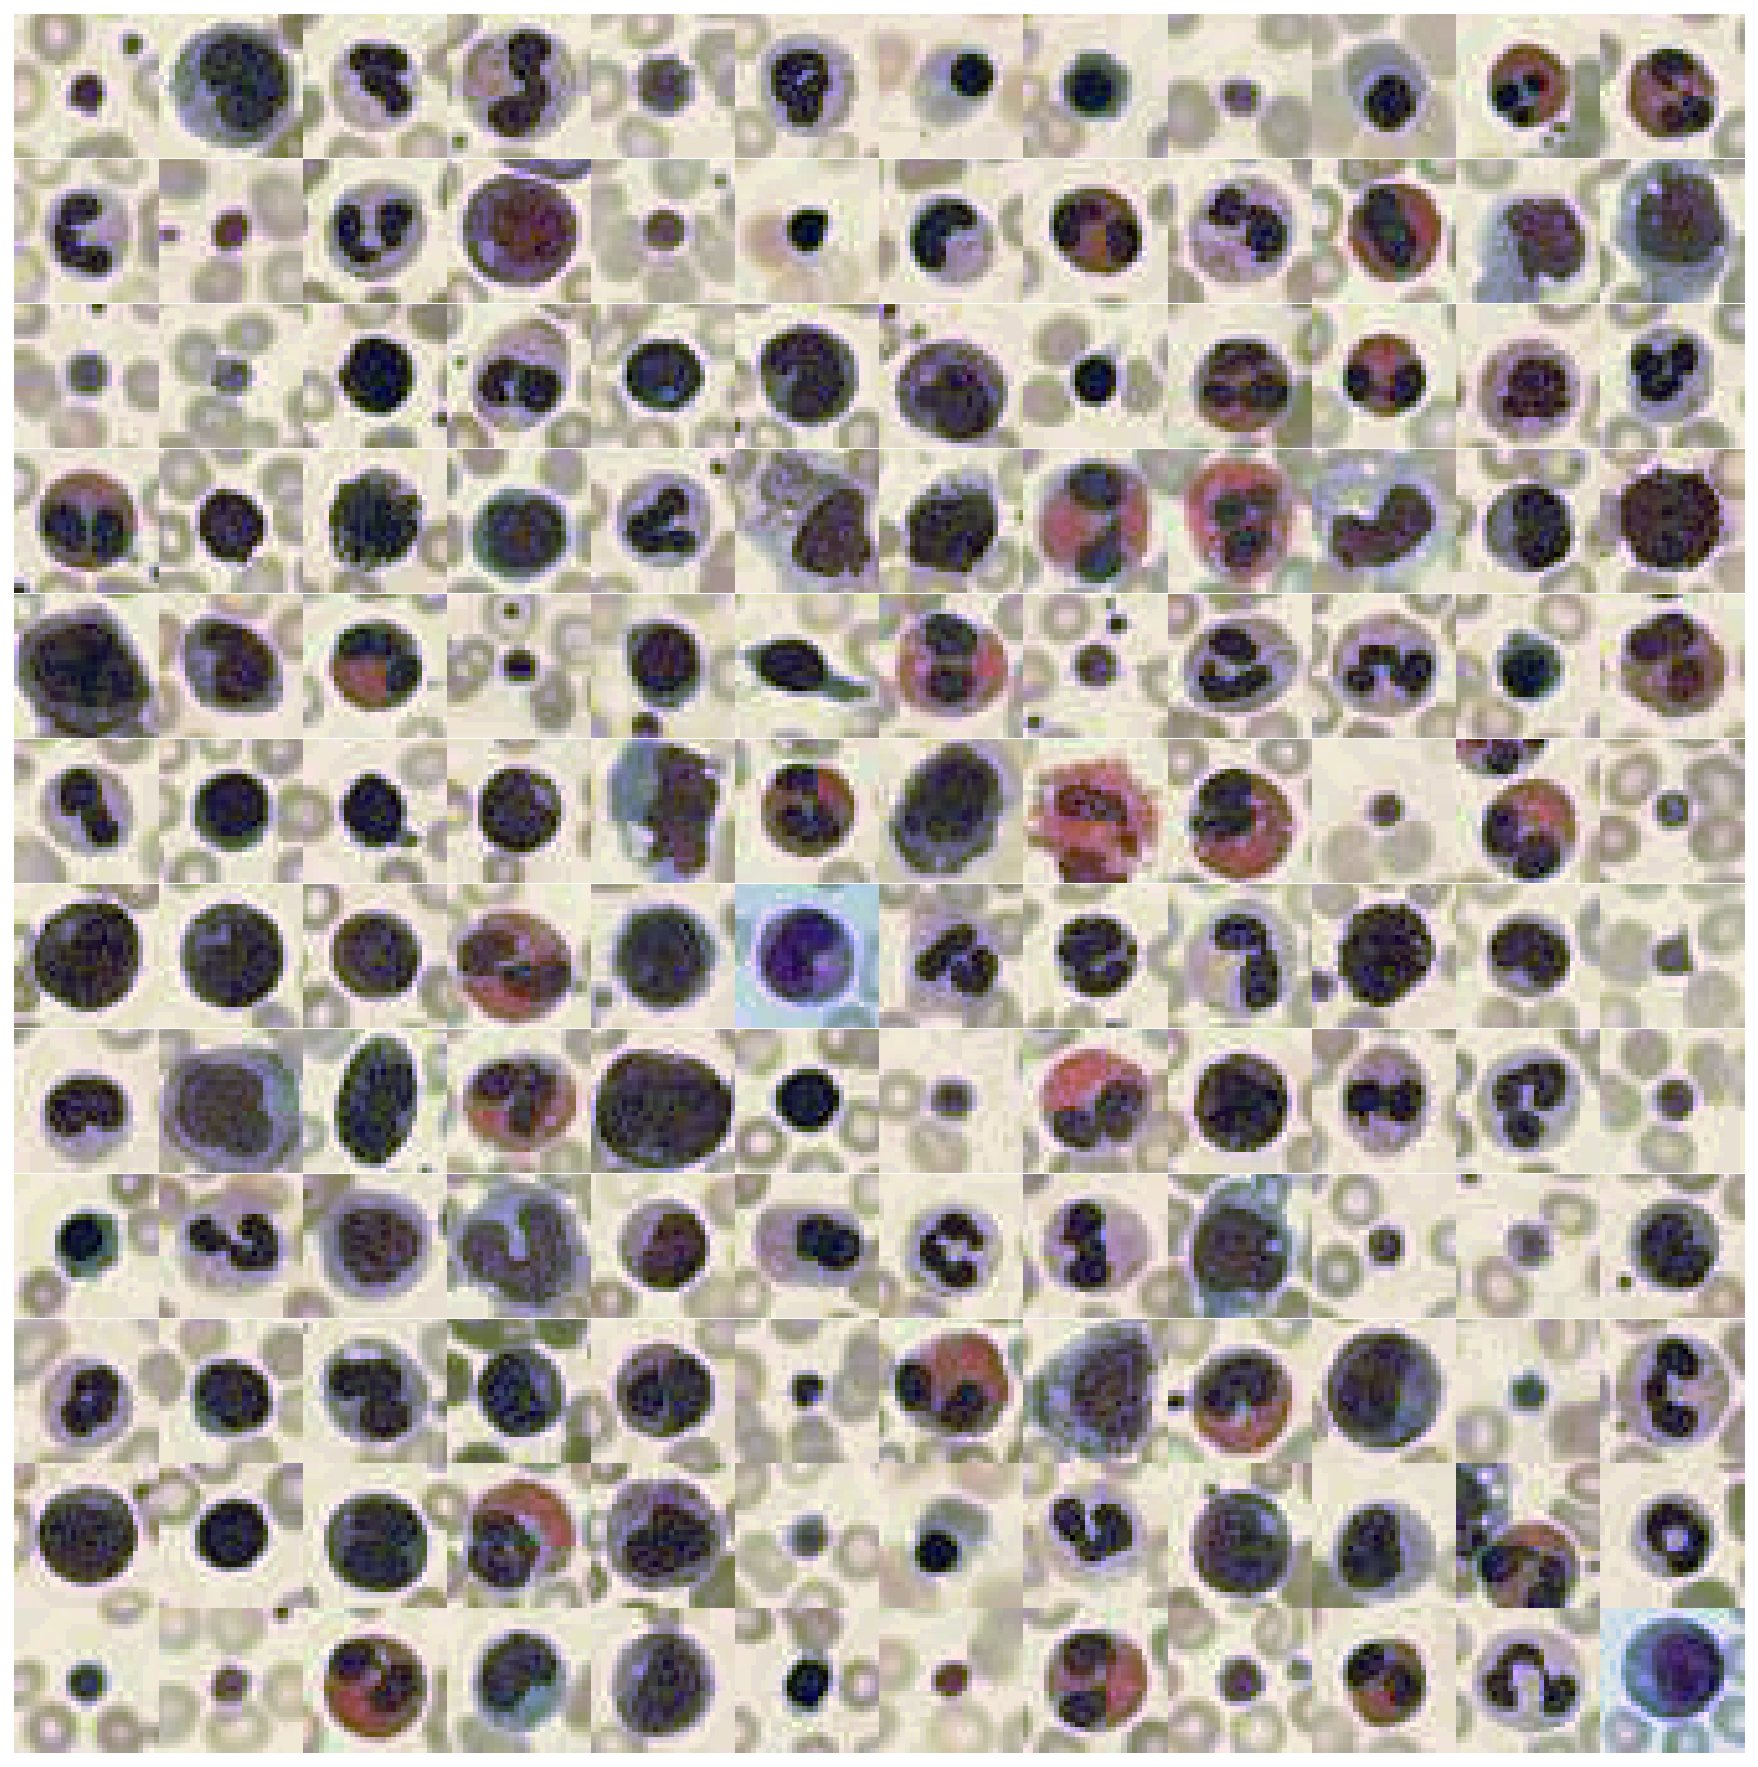

<IPython.core.display.Javascript object>

In [16]:
# Convert data back into image space
X_tr_stretch = X_tr_stretch.reshape(X_tr.shape)
X_va_stretch = X_va_stretch.reshape(X_va.shape)
X_te_stretch = X_te_stretch.reshape(X_te.shape)

# Plot dataset
plot_dataset(X_tr_stretch)

## 3. PCA transformation

Last but certainly not least of our three options, let's use a PCA approach to transform the original RGB color values into a new 3D space, where each of these three new axis explains as much variance as possible. **Note:** For this approach we will use the original RGB color values, but we could of course also use the just realigned and stretched values as well.

So what do the original RGB color values look like in this new PCA color space?

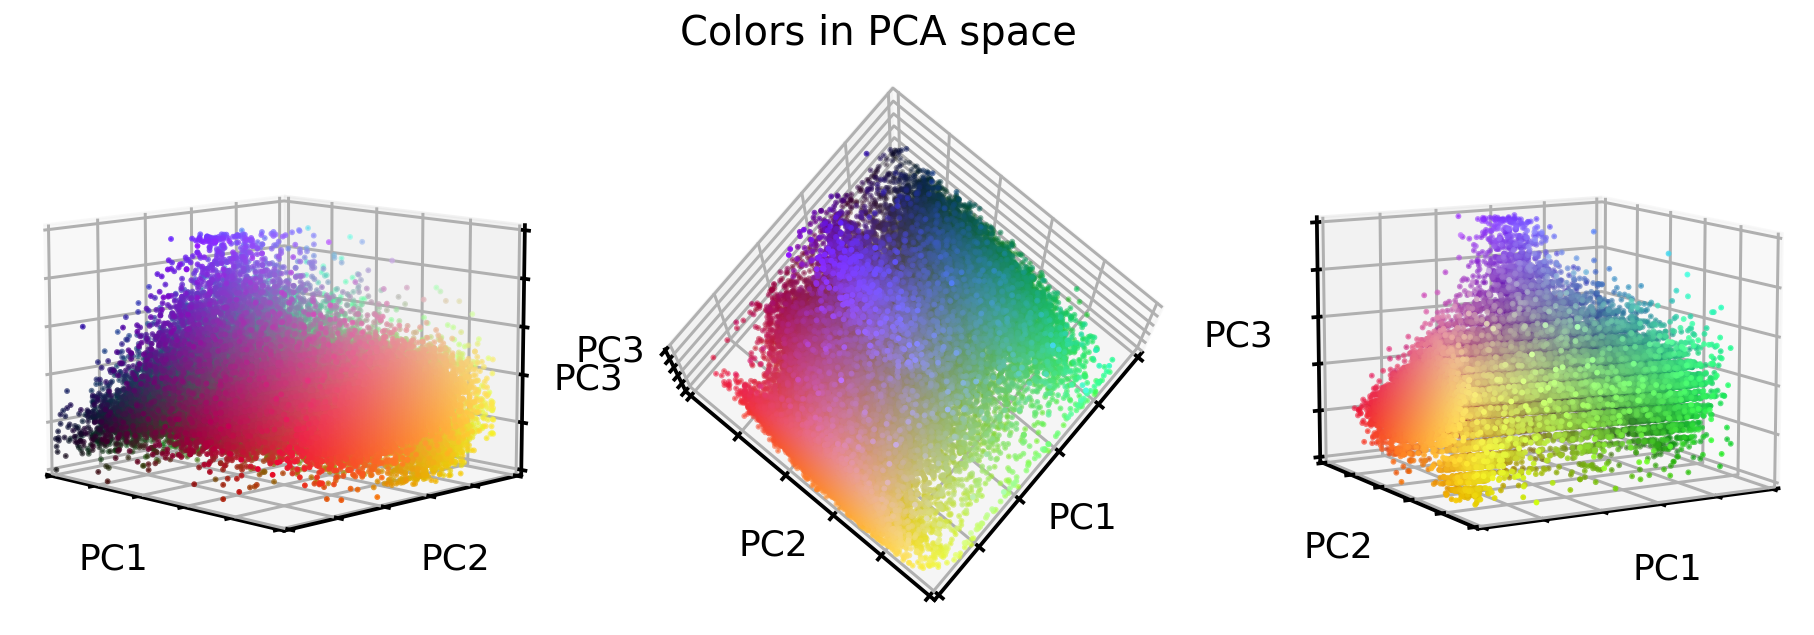

<IPython.core.display.Javascript object>

In [17]:
# Train PCA decomposition on original RGB values
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_tr.reshape(-1, 3))

# Transform all data sets into new PCA space
X_tr_pca = pca.transform(X_tr.reshape(-1, 3))
X_va_pca = pca.transform(X_va.reshape(-1, 3))
X_te_pca = pca.transform(X_te.reshape(-1, 3))

# Stretch and clip data
xmin_tr = np.percentile(X_tr_pca, 0.05, axis=0)
X_tr_pca -= xmin_tr
X_va_pca -= xmin_tr
X_te_pca -= xmin_tr
xmax_tr = np.percentile(X_tr_pca, 99.95, axis=0)
X_tr_pca /= xmax_tr
X_va_pca /= xmax_tr
X_te_pca /= xmax_tr
X_tr_pca = np.clip(X_tr_pca, 0, 1)
X_va_pca = np.clip(X_va_pca, 0, 1)
X_te_pca = np.clip(X_te_pca, 0, 1)

# Flip first component
X_tr_pca[:, 0] = 1 - X_tr_pca[:, 0]
X_va_pca[:, 0] = 1 - X_va_pca[:, 0]
X_te_pca[:, 0] = 1 - X_te_pca[:, 0]

# Extract a few RGB color values
X_colors = X_tr_pca[::100].reshape(-1, 3)

# Plot color values in 3D space
fig = plt.figure(figsize=(16, 5))

# Loop through 3 different views
for i, view in enumerate([[-45, 10], [40, 80], [60, 10]]):
    ax = fig.add_subplot(1, 3, i + 1, projection="3d")
    ax.scatter(X_colors[:, 0], X_colors[:, 1], X_colors[:, 2], facecolors=X_colors, s=2)
    ax.set_xlabel("PC1")
    ax.set_ylabel("PC2")
    ax.set_zlabel("PC3")
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.zaxis.set_ticklabels([])
    ax.view_init(azim=view[0], elev=view[1], vertical_axis="z")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
plt.suptitle("Colors in PCA space", fontsize=20)
plt.show()

Interesting, the stretching worked very well! But what about the images? Let's see.

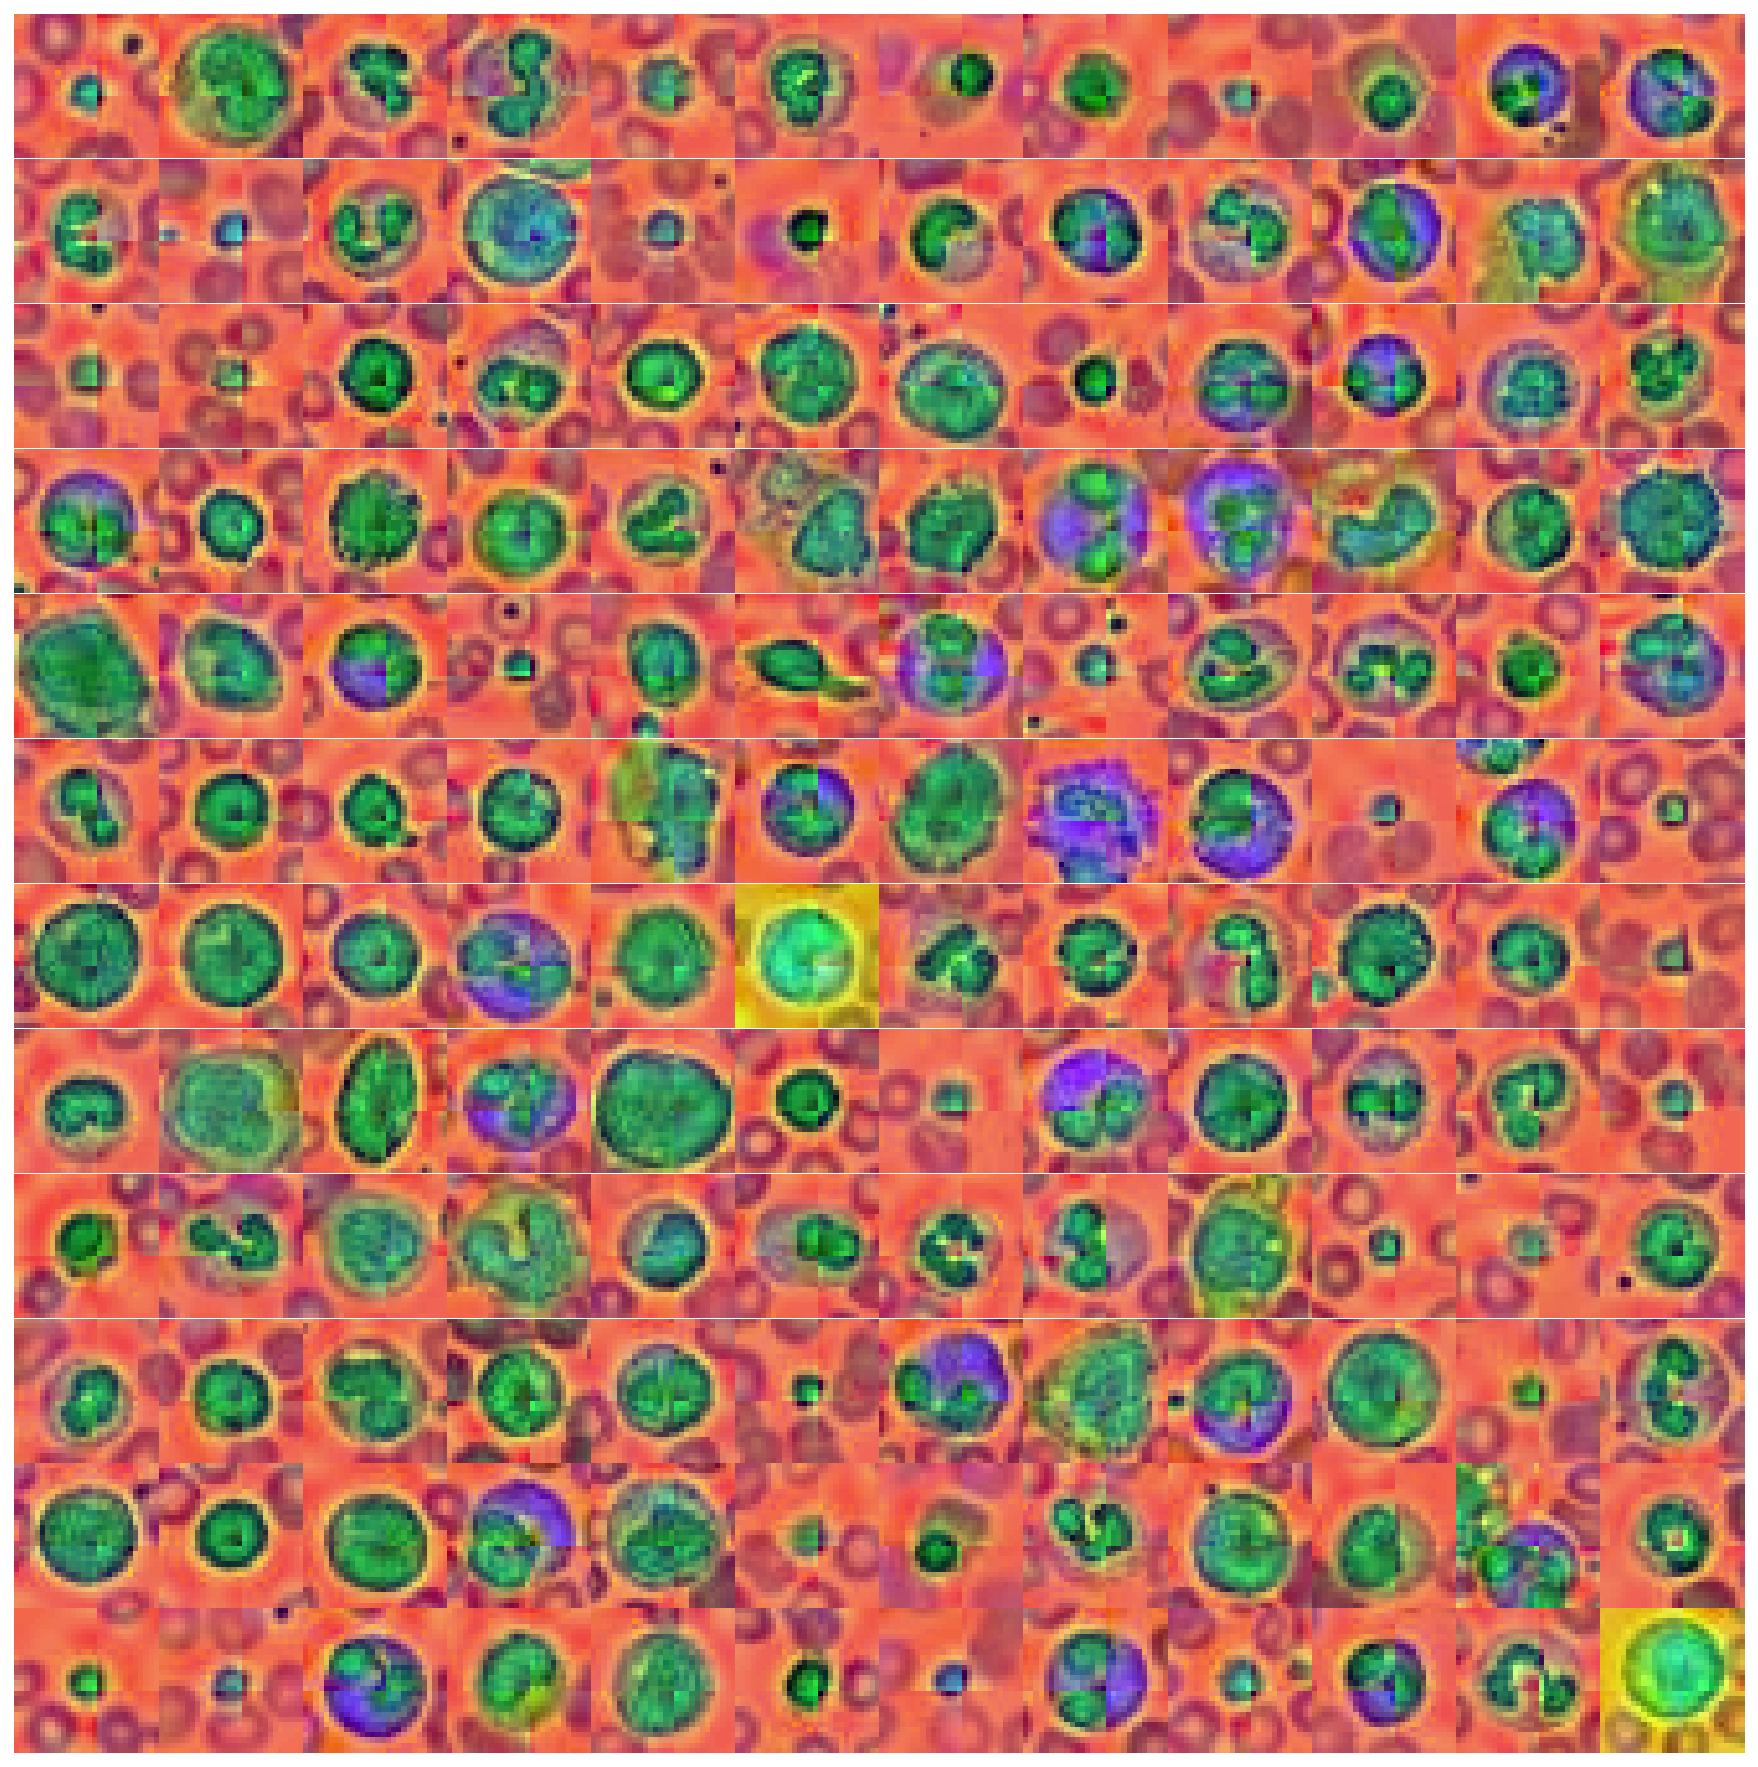

<IPython.core.display.Javascript object>

In [18]:
# Convert data back into image space
X_tr_pca = X_tr_pca.reshape(X_tr.shape)
X_va_pca = X_va_pca.reshape(X_va.shape)
X_te_pca = X_te_pca.reshape(X_te.shape)

# Plot dataset
plot_dataset(X_tr_pca)

That looks interesting as well. Unique colors, e.g. background, nucleus and the thing that surrounds the nucleus all have unique colors. However, our PCA transformation also brought forward an artifact in the images - the cross like color border in the middle of the image. It is unclear where this is coming from, but I assume that it's due to the dataset manipulation that MedMNIST introduced by downsampling the original dataset.

# Feature correlation

Before moving on to the next part of our investigation (i.e. testing if these color manipulation help a convolutional neural network to classify the 10 target classes), let's take a quick look at how these new color values correlate to each other.

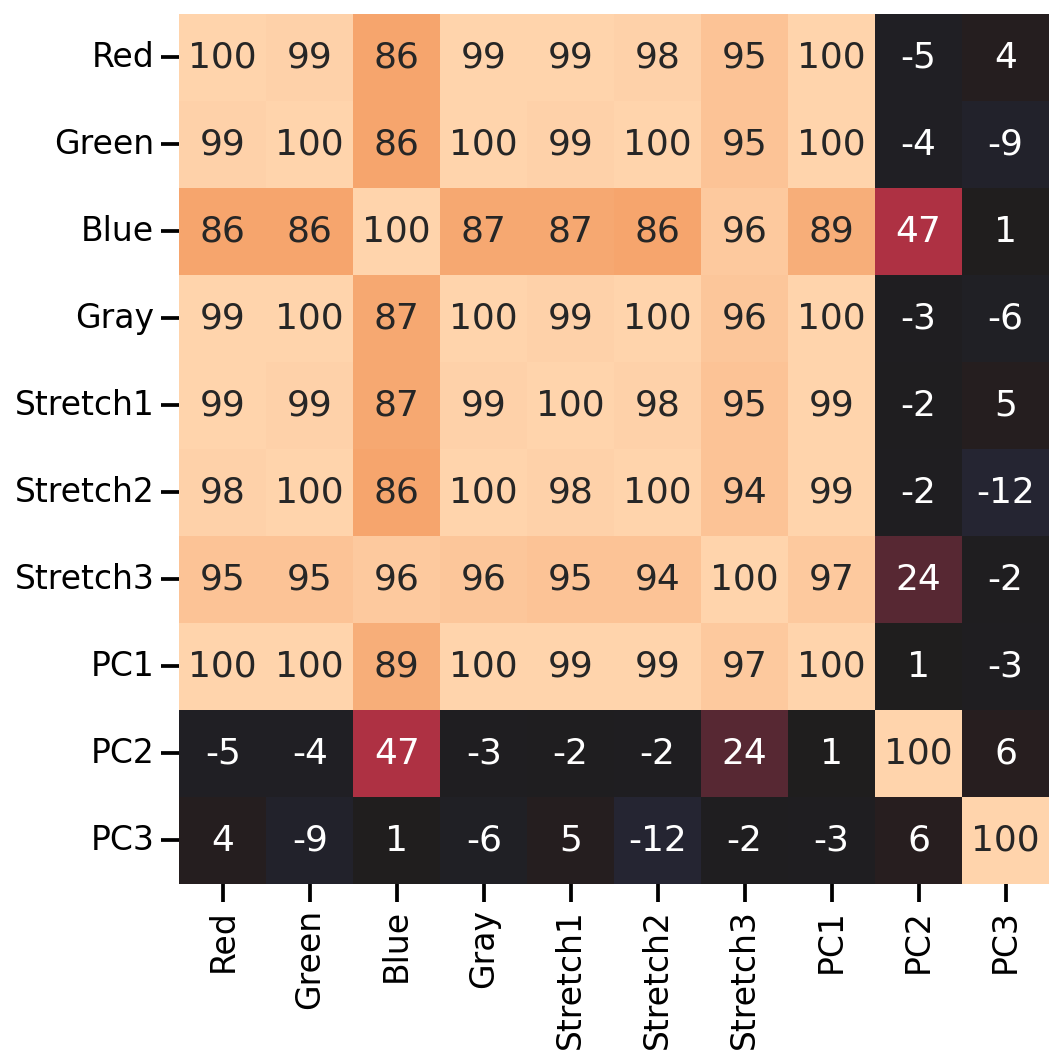

<IPython.core.display.Javascript object>

In [19]:
# Combine all images in one big dataframe
X_tr_all = np.vstack([X_tr.T, X_tr_gray.T, X_tr_stretch.T, X_tr_pca.T]).T
X_va_all = np.vstack([X_va.T, X_va_gray.T, X_va_stretch.T, X_va_pca.T]).T
X_te_all = np.vstack([X_te.T, X_te_gray.T, X_te_stretch.T, X_te_pca.T]).T

# Compute correlation matrix between all color features
corr_all = np.corrcoef(X_tr_all.reshape(-1, X_tr_all.shape[-1]).T)
cols = ["Red", "Green", "Blue", "Gray",
        "Stretch1", "Stretch2", "Stretch3",
        "PC1", "PC2", "PC3"]

plt.figure(figsize=(8, 8))
sns.heatmap(
    100 * corr_all,
    square=True,
    center=0,
    annot=True,
    fmt=".0f",
    cbar=False,
    xticklabels=cols,
    yticklabels=cols,
)

As we can see, many of the new color features correlate highly with the original RGB values (except for the 2nd and 3rd PCA features). So let's see if any of our color manipulation help with the image classification.

# Testing color manipulations in image classification

Let's see if our color manipulation is helping a convolutional neural network to classify the 8 target classes. To do so, let's create a 'smallish' ResNet model and train it on all 4 versions of our dataset (i.e. original, grayscale, stretched, and PCA).

In [20]:
# The code for this ResNet architecture was adapted from here:
# https://towardsdatascience.com/building-a-resnet-in-keras-e8f1322a49ba
from tensorflow import Tensor
from tensorflow.keras.layers import (Input, Conv2D, ReLU, BatchNormalization, Add,
                                     AveragePooling2D, Flatten, Dense, Dropout)
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(
        kernel_size=kernel_size,
        strides=(1 if not downsample else 2),
        filters=filters,
        padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size, strides=1, filters=filters, padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1, strides=2, filters=filters, padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out


def create_res_net(in_shape=(28, 28, 3)):

    inputs = Input(shape=in_shape)
    num_filters = 32

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3, strides=1, filters=num_filters, padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [2, 2]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j == 0 and i != 0), filters=num_filters)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dense(128, activation="relu")(t)
    t = Dropout(0.5)(t)
    outputs = Dense(8, activation="softmax")(t)

    model = Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

    return model

def run_resnet(X_tr, y_tr, X_va, y_va, epochs=200, verbose=0):
    """Support function to train ResNet model"""

    # Create Model
    model = create_res_net(in_shape=X_tr.shape[1:])

    # Creates 'EarlyStopping' callback
    from tensorflow import keras

    earlystopping_cb = keras.callbacks.EarlyStopping(
        patience=10, restore_best_weights=True)

    # Train model
    history = model.fit(
        X_tr,
        y_tr,
        batch_size=120,
        epochs=epochs,
        validation_data=(X_va, y_va),
        callbacks=[earlystopping_cb],
        verbose=verbose,
    )

    return model, history

def plot_history(history):
    """Support function to plot model history"""

    # Plots neural network performance metrics for train and validation
    fig, axs = plt.subplots(1, 2, figsize=(15, 4))
    results = pd.DataFrame(history.history)
    results[["accuracy", "val_accuracy"]].plot(ax=axs[0])
    results[["loss", "val_loss"]].plot(ax=axs[1], logy=True)
    plt.tight_layout()
    plt.show()

def plot_classification_report(X_te, y_te, model):
    """Support function to plot classification report"""

    # Show classification report
    from sklearn.metrics import classification_report

    y_pred = model.predict(X_te).argmax(axis=1)
    print(classification_report(y_te.ravel(), y_pred))

    # Show confusion matrix
    from sklearn.metrics import ConfusionMatrixDisplay

    fig, ax = plt.subplots(1, 2, figsize=(16, 7))
    ConfusionMatrixDisplay.from_predictions(
        y_te.ravel(), y_pred, ax=ax[0], colorbar=False, cmap="inferno_r")

    from sklearn.metrics import ConfusionMatrixDisplay

    ConfusionMatrixDisplay.from_predictions(
        y_te.ravel(), y_pred, normalize="true", ax=ax[1],
        values_format=".1f", colorbar=False, cmap="inferno_r")

<IPython.core.display.Javascript object>

## Classification performance on original data set

Let's establish a baseline by first training a ResNet model on the original dataset. The following shows the model's performance (on accuracy and loss) during training.

2022-01-01 18:38:06.358127: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


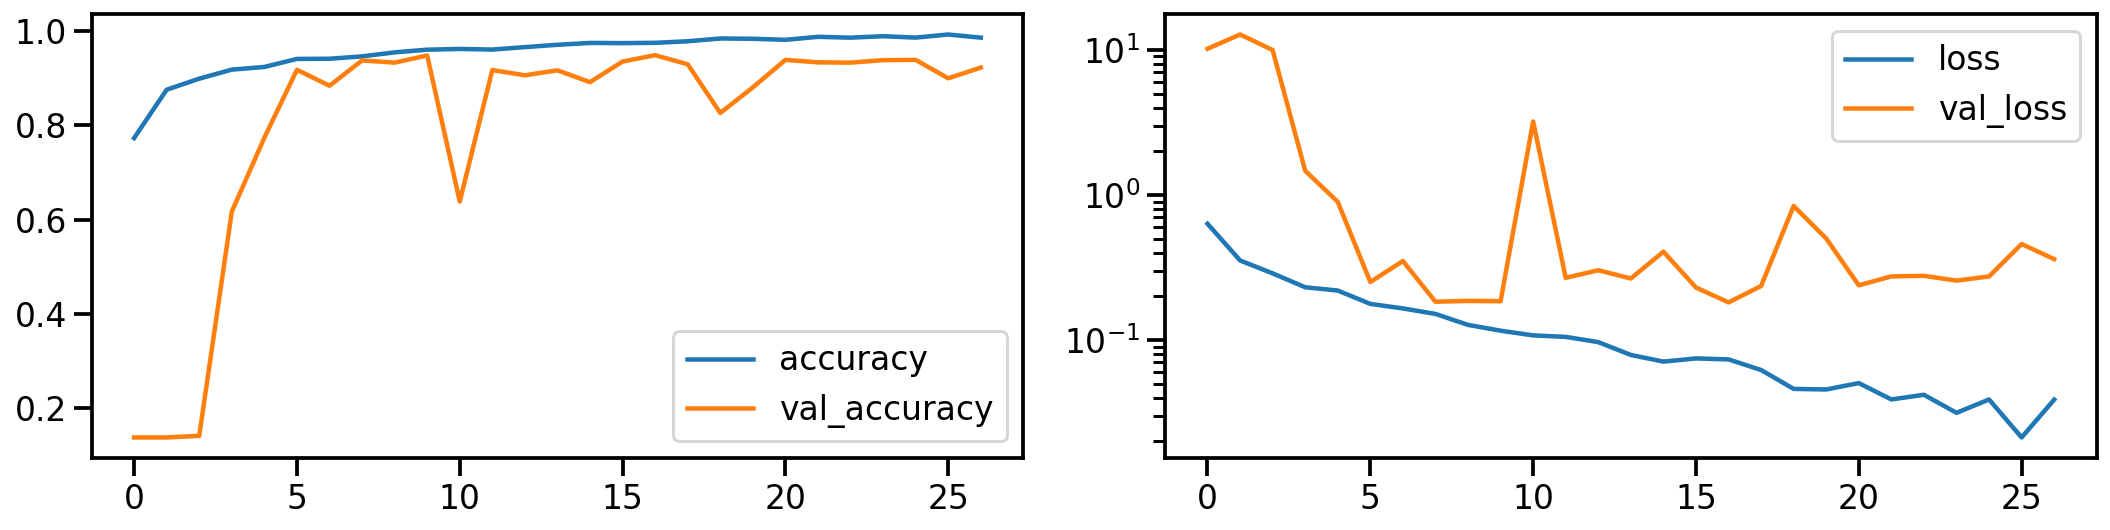

<IPython.core.display.Javascript object>

In [21]:
# Train model
model_orig, history_orig = run_resnet(X_tr, y_tr, X_va, y_va)

# Show model performance during training
plot_history(history_orig)

Now that the model is trained, let's see how well it's capable in detecting the 8 target classes, by looking at the corresponding confusion matrices. On the left the confusion matrix shows the number of correctly/falsely identified samples, while on the right it shows the proportional values per target class.

107/107 [==============================] - 3s 30ms/step - loss: 0.1952 - accuracy: 0.9421
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       244
           1       1.00      0.98      0.99       624
           2       0.95      0.92      0.93       311
           3       0.88      0.88      0.88       579
           4       0.91      0.97      0.94       243
           5       0.84      0.94      0.89       284
           6       0.97      0.96      0.96       666
           7       1.00      0.97      0.99       470

    accuracy                           0.94      3421
   macro avg       0.93      0.94      0.94      3421
weighted avg       0.94      0.94      0.94      3421



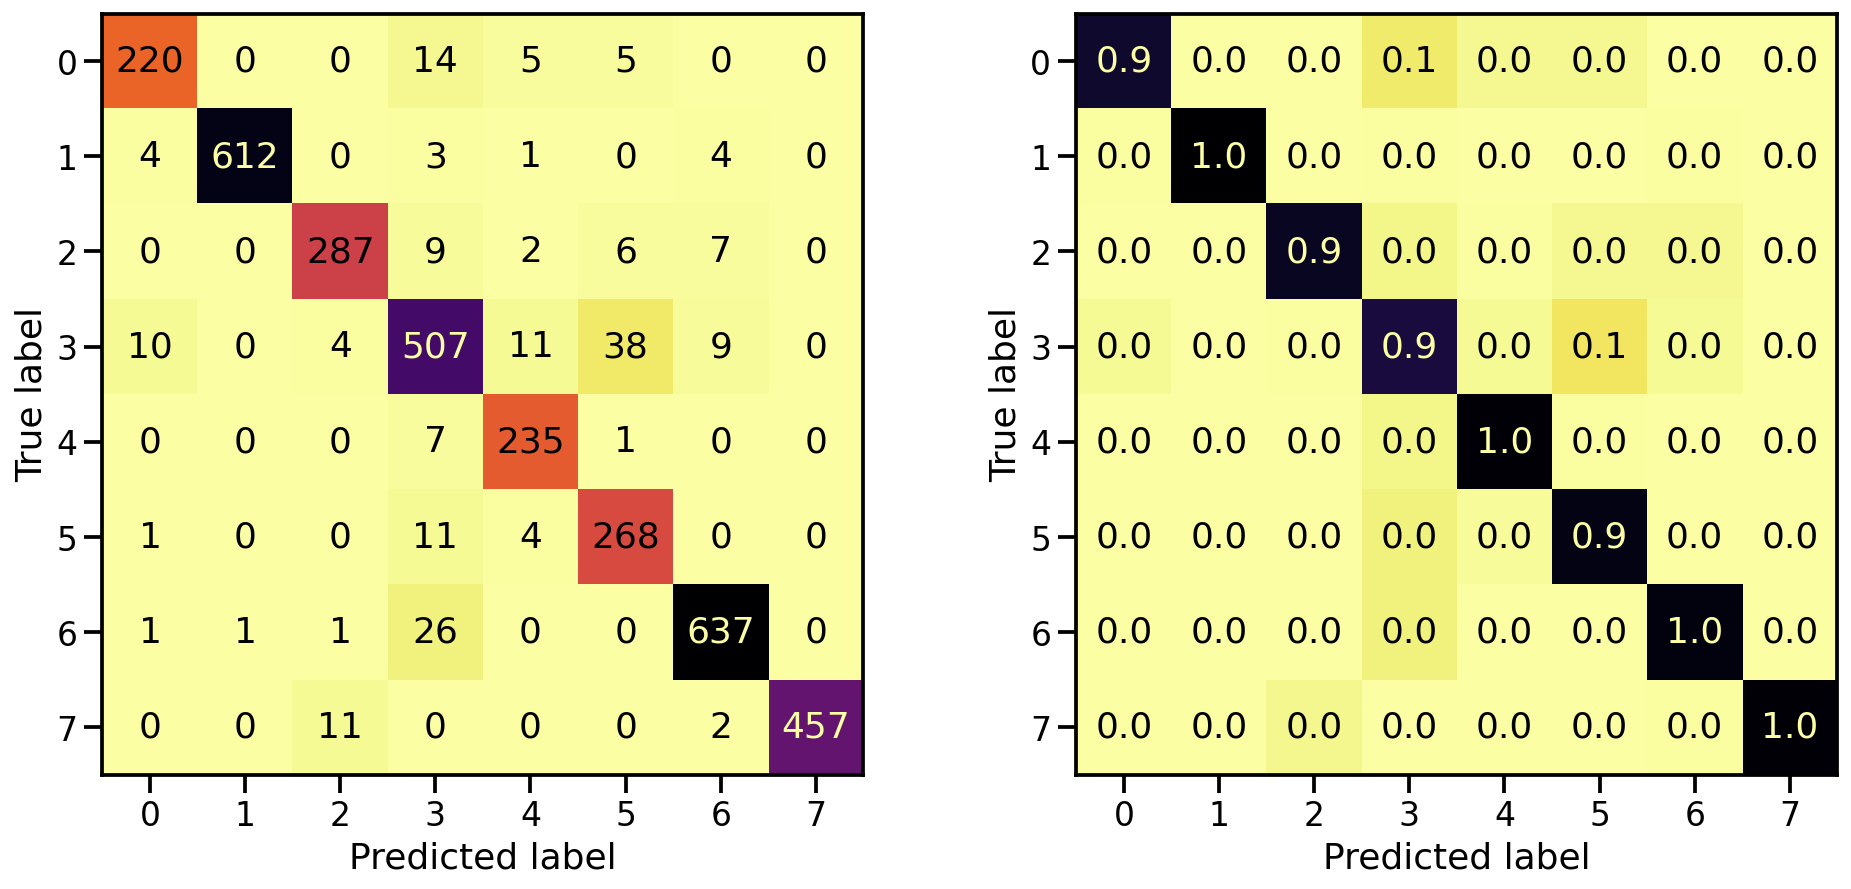

<IPython.core.display.Javascript object>

In [22]:
# Evaluate Model
loss_orig_tr, acc_orig_tr = model_orig.evaluate(X_tr, y_tr)
loss_orig_va, acc_orig_va = model_orig.evaluate(X_va, y_va)
loss_orig_te, acc_orig_te = model_orig.evaluate(X_te, y_te)

# Report classification report and confusion matrix
plot_classification_report(X_te, y_te, model_orig)

## Classification performance on grayscale data set

Now let's do the same for the gray scale transformed images. How does the model performance during training look like?

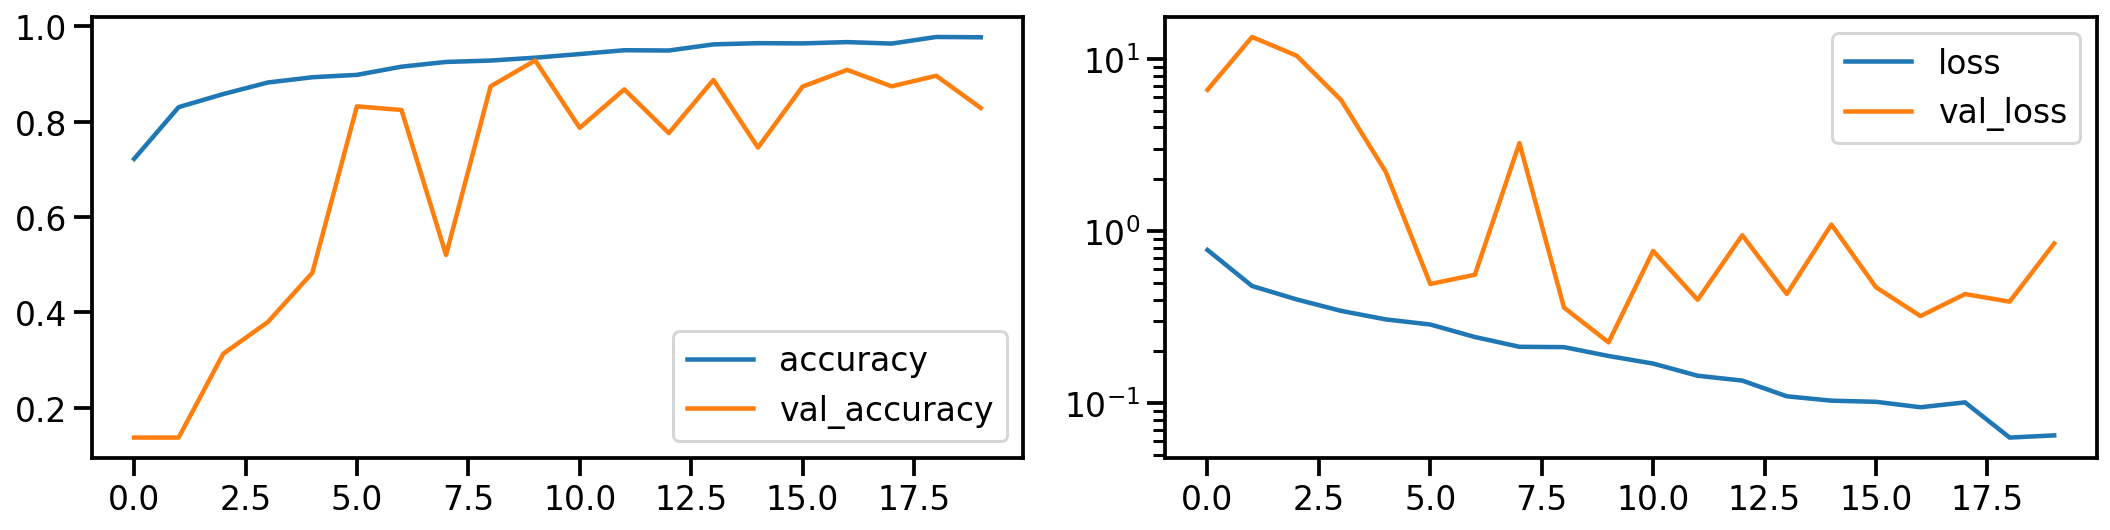

<IPython.core.display.Javascript object>

In [23]:
# Train model
model_gray, history_gray = run_resnet(X_tr_gray, y_tr, X_va_gray, y_va)

# Show model performance during training
plot_history(history_gray)

And what about the confusion matrices?

107/107 [==============================] - 3s 31ms/step - loss: 0.2407 - accuracy: 0.9220
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       244
           1       0.98      0.94      0.96       624
           2       0.96      0.92      0.94       311
           3       0.87      0.83      0.85       579
           4       0.81      0.96      0.88       243
           5       0.82      0.84      0.83       284
           6       0.97      0.97      0.97       666
           7       0.99      1.00      0.99       470

    accuracy                           0.92      3421
   macro avg       0.91      0.92      0.91      3421
weighted avg       0.92      0.92      0.92      3421



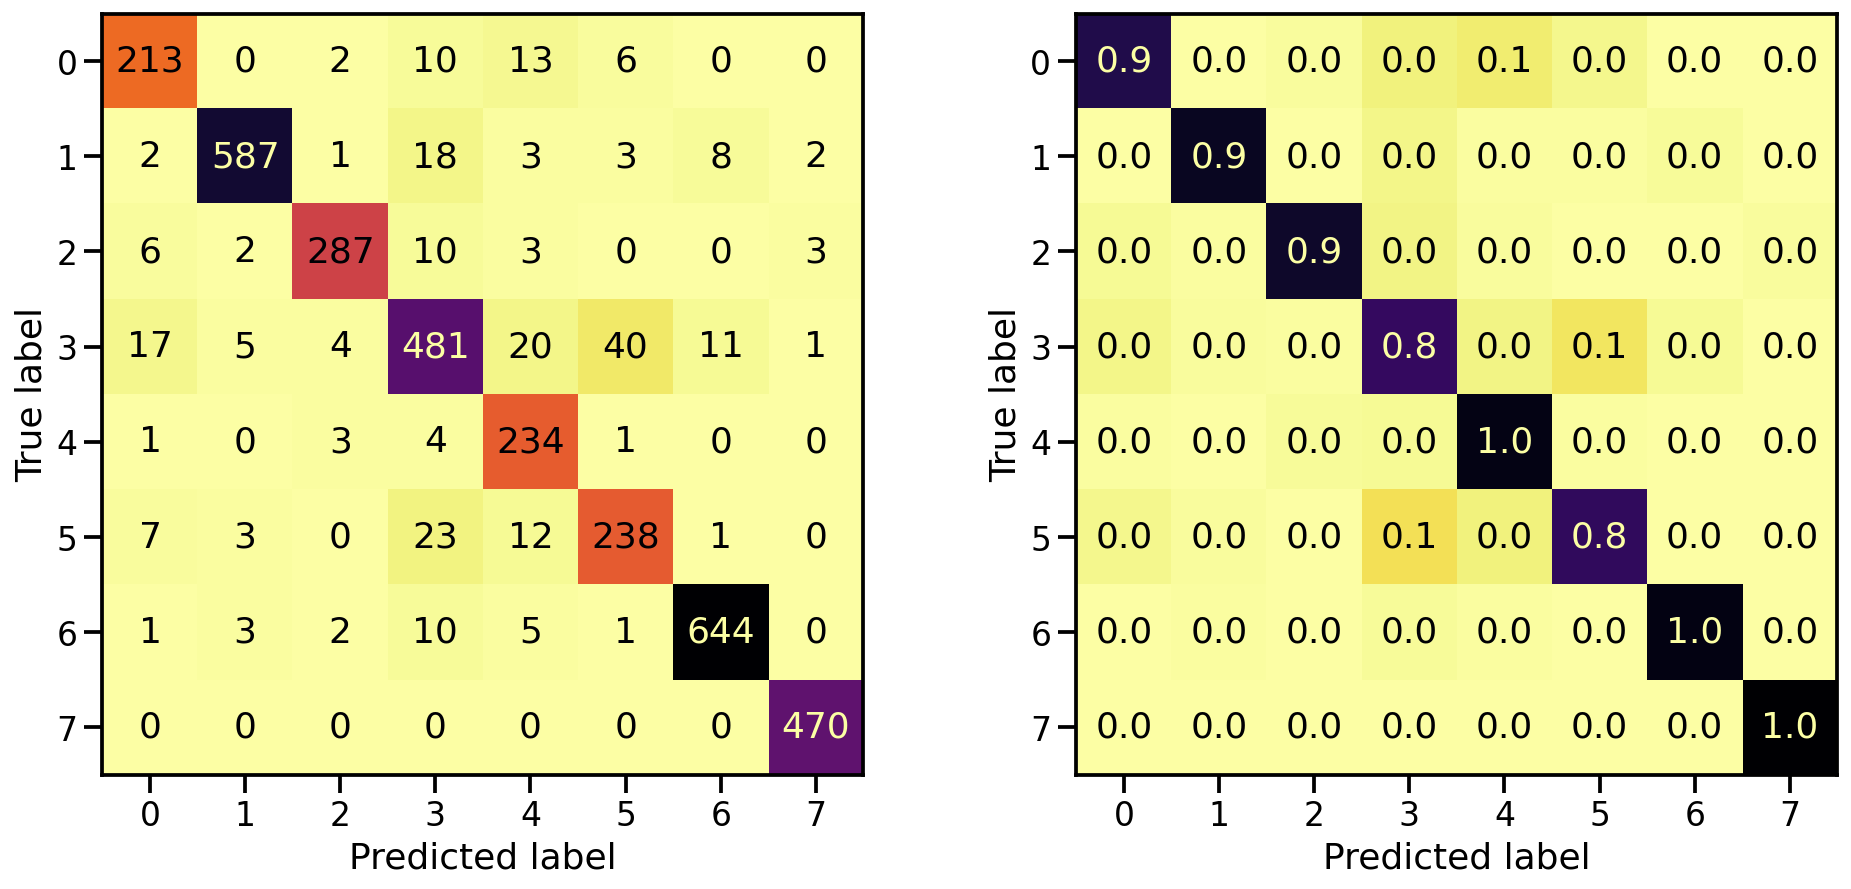

<IPython.core.display.Javascript object>

In [24]:
# Evaluate Model
loss_gray_tr, acc_gray_tr = model_gray.evaluate(X_tr_gray, y_tr)
loss_gray_va, acc_gray_va = model_gray.evaluate(X_va_gray, y_va)
loss_gray_te, acc_gray_te = model_gray.evaluate(X_te_gray, y_te)

# Report classification report and confusion matrix
plot_classification_report(X_te_gray, y_te, model_gray)

## Classification performance on realigned and stretched data set

Now let's do the same for the realigned and stretched images. How does the model performance during training look like?

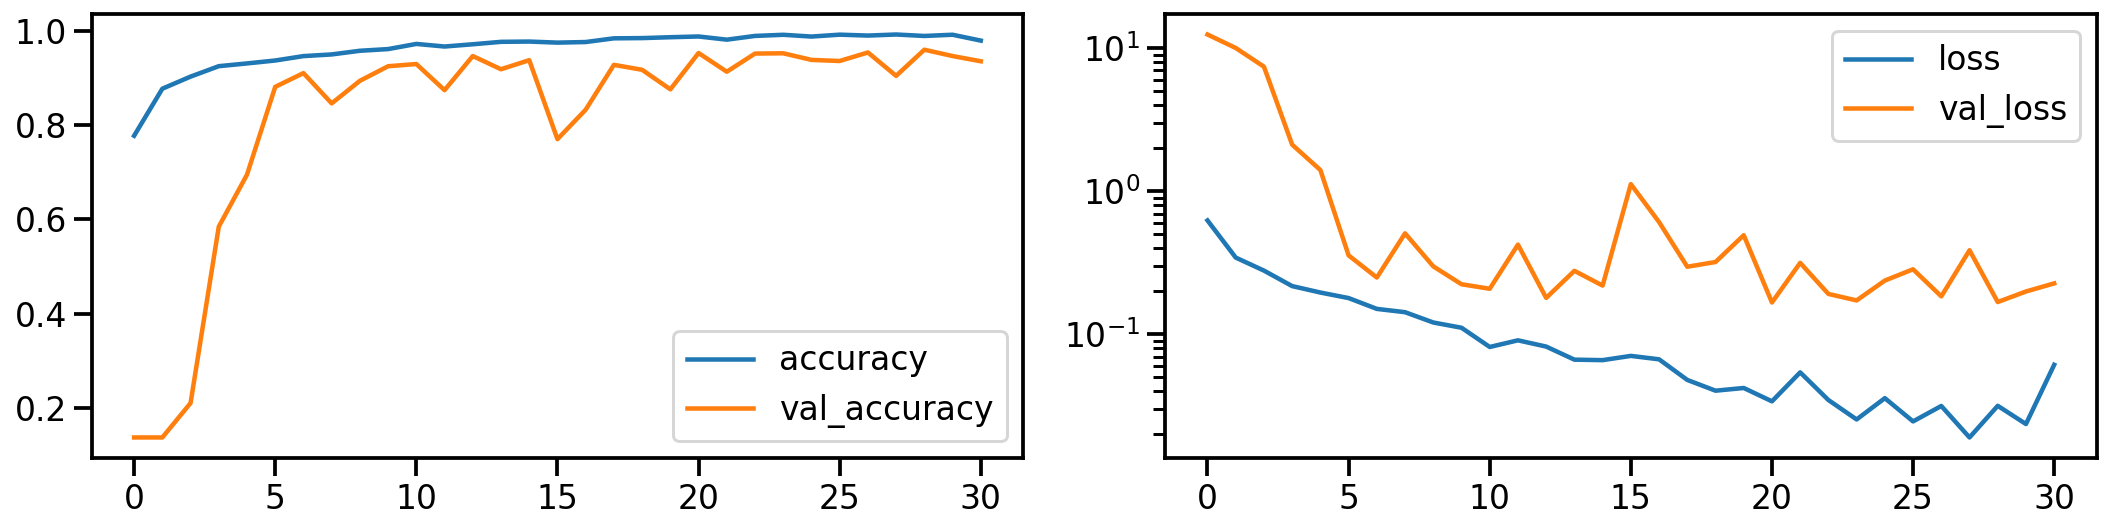

<IPython.core.display.Javascript object>

In [25]:
# Train model
model_stretch, history_stretch = run_resnet(X_tr_stretch, y_tr, X_va_stretch, y_va)

# Show model performance during training
plot_history(history_stretch)

And what about the confusion matrices?

107/107 [==============================] - 3s 31ms/step - loss: 0.1975 - accuracy: 0.9491
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       244
           1       0.99      0.99      0.99       624
           2       0.96      0.97      0.97       311
           3       0.92      0.86      0.89       579
           4       0.97      0.93      0.95       243
           5       0.88      0.88      0.88       284
           6       0.97      0.97      0.97       666
           7       0.99      1.00      1.00       470

    accuracy                           0.95      3421
   macro avg       0.94      0.95      0.94      3421
weighted avg       0.95      0.95      0.95      3421



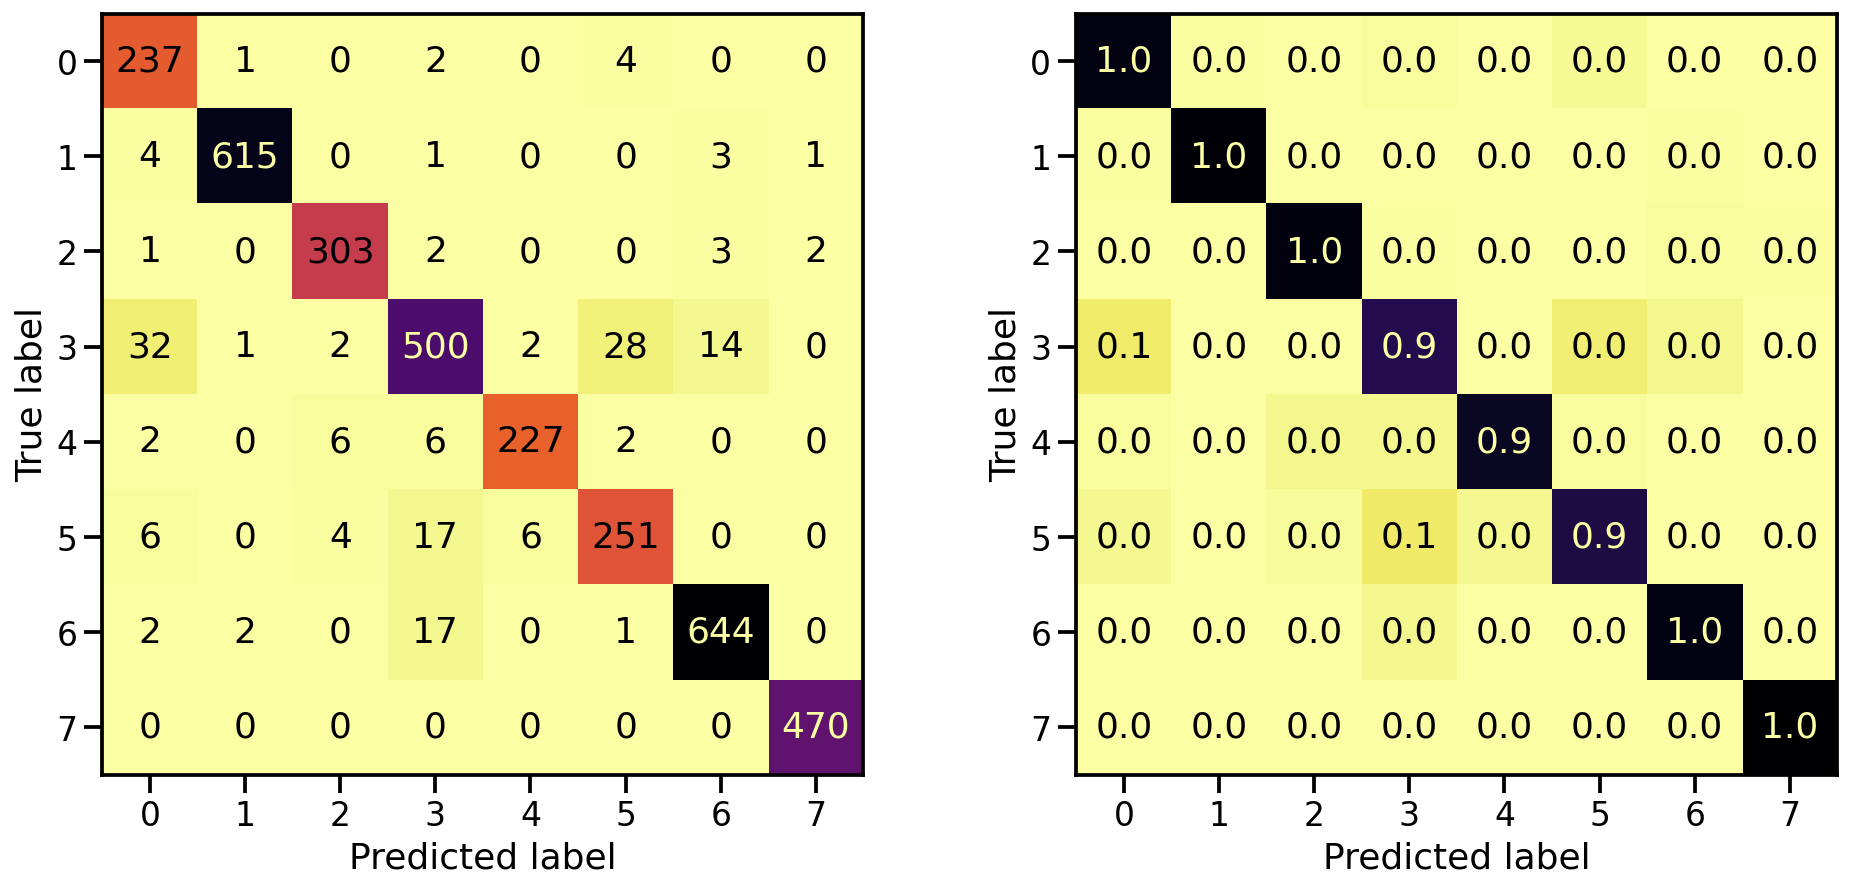

<IPython.core.display.Javascript object>

In [28]:
# Evaluate Model
loss_stretch_tr, acc_stretch_tr = model_stretch.evaluate(X_tr_stretch, y_tr)
loss_stretch_va, acc_stretch_va = model_stretch.evaluate(X_va_stretch, y_va)
loss_stretch_te, acc_stretch_te = model_stretch.evaluate(X_te_stretch, y_te)

# Report classification report and confusion matrix
plot_classification_report(X_te_stretch, y_te, model_stretch)

## Classification performance on PCA transformed data set

Now let's do the same for the PCA transformed images. How does the model performance during training look like?

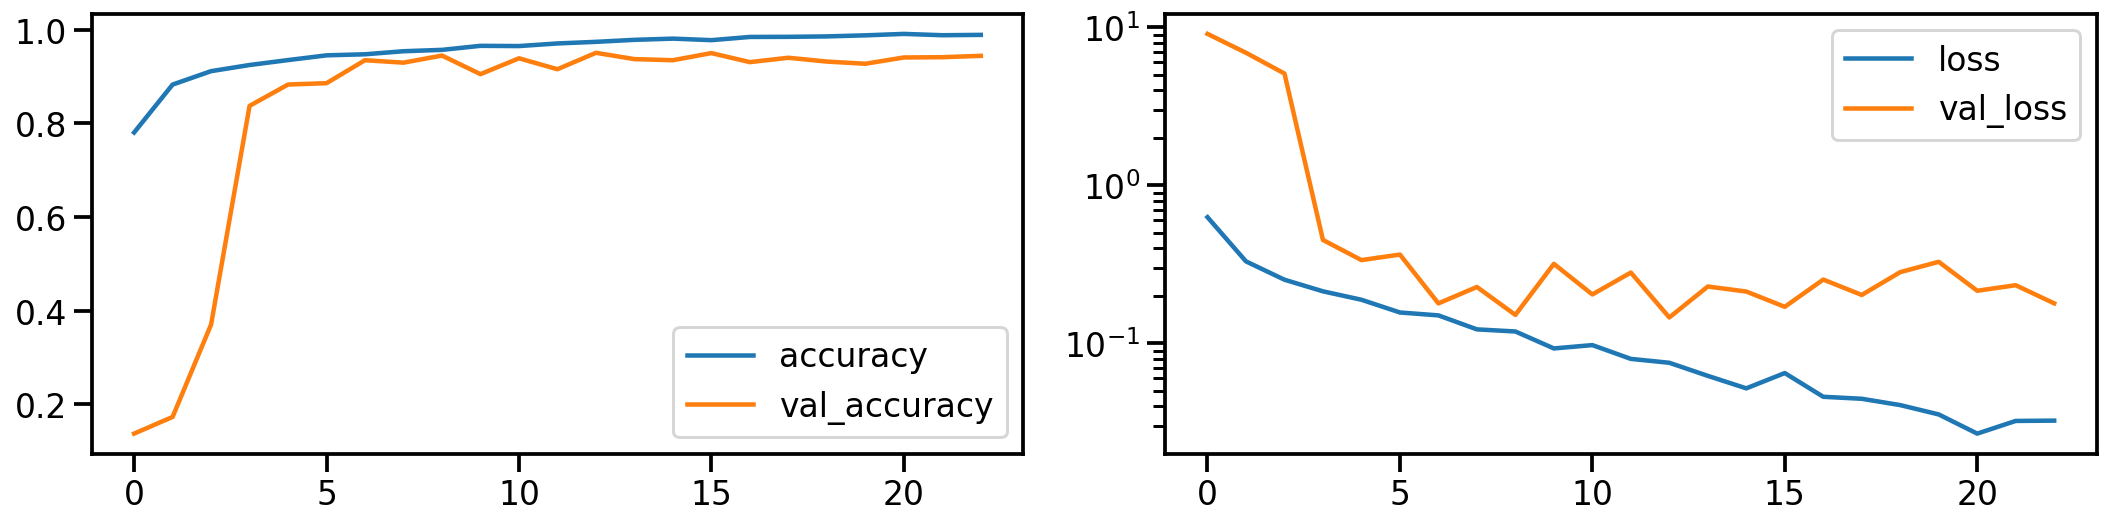

<IPython.core.display.Javascript object>

In [29]:
# Train model
model_pca, history_pca = run_resnet(X_tr_pca, y_tr, X_va_pca, y_va)

# Show model performance during training
plot_history(history_pca)

And what about the confusion matrices?

107/107 [==============================] - 3s 31ms/step - loss: 0.1898 - accuracy: 0.9448
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       244
           1       0.99      0.98      0.99       624
           2       0.94      0.95      0.94       311
           3       0.87      0.89      0.88       579
           4       0.91      0.96      0.94       243
           5       0.91      0.89      0.90       284
           6       0.95      0.96      0.96       666
           7       1.00      1.00      1.00       470

    accuracy                           0.94      3421
   macro avg       0.94      0.94      0.94      3421
weighted avg       0.95      0.94      0.94      3421



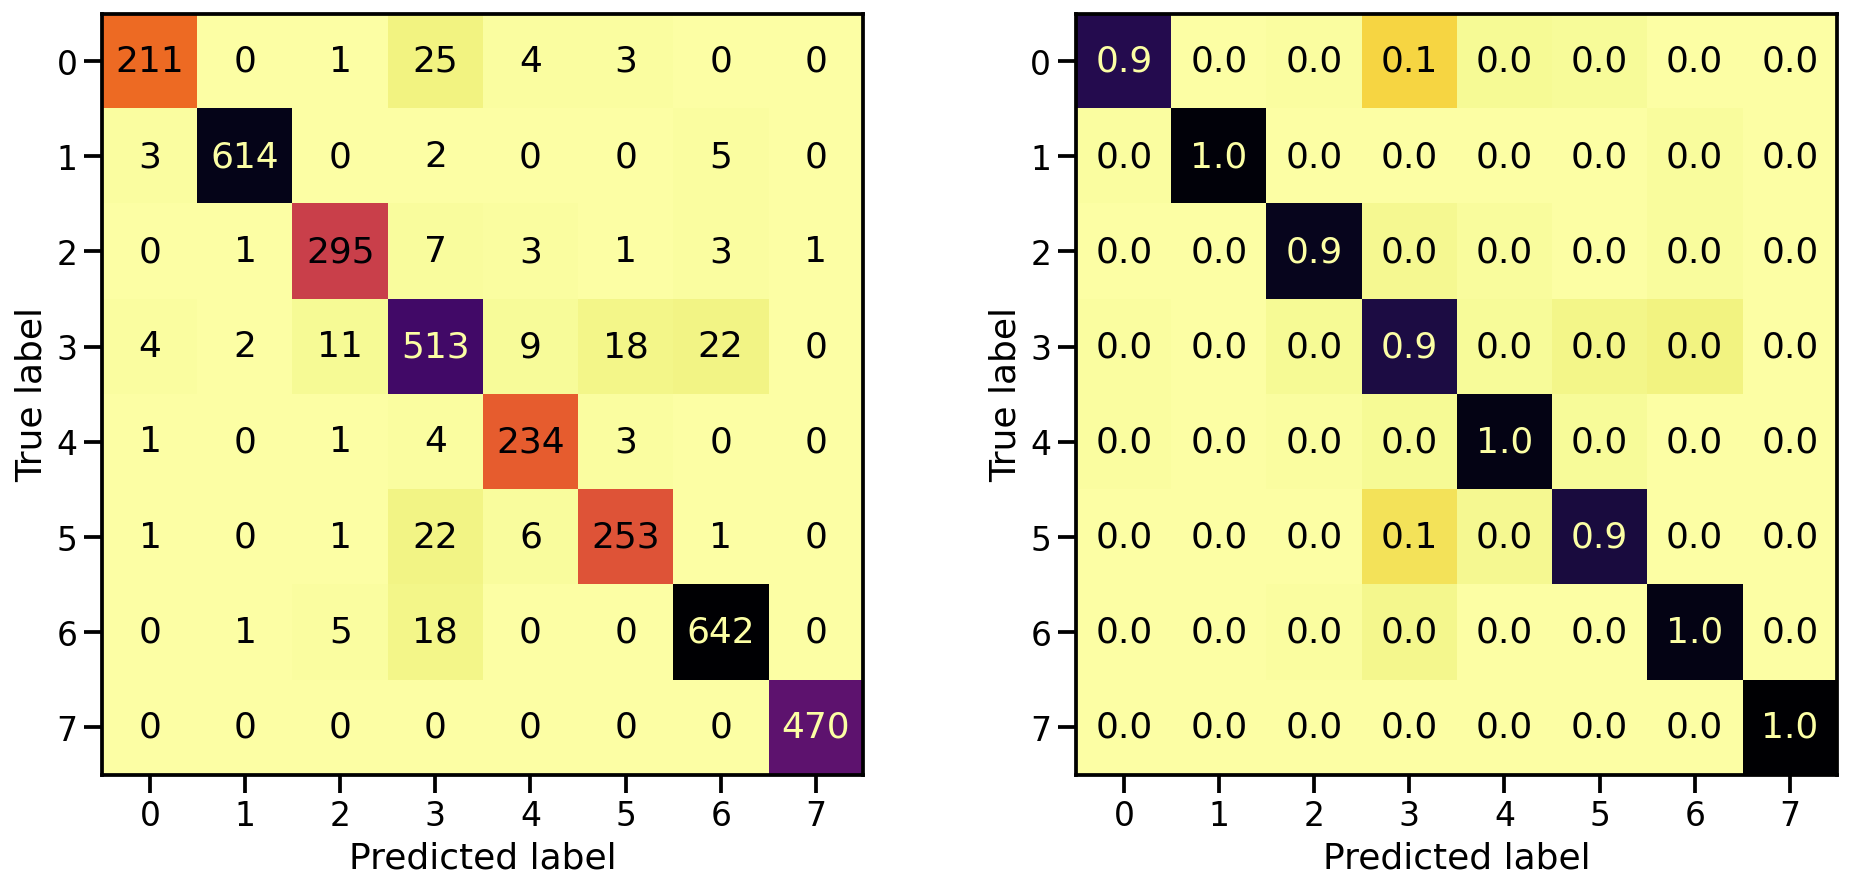

<IPython.core.display.Javascript object>

In [30]:
# Evaluate Model
loss_pca_tr, acc_pca_tr = model_pca.evaluate(X_tr_pca, y_tr)
loss_pca_va, acc_pca_va = model_pca.evaluate(X_va_pca, y_va)
loss_pca_te, acc_pca_te = model_pca.evaluate(X_te_pca, y_te)

# Report classification report and confusion matrix
plot_classification_report(X_te_pca, y_te, model_pca)

# Model investigation

Now that we trained all of these individual models, let's see how they relate and how they differ. First, let's compare in what way these different models predict the same values by plotting their individual predictions for the test set next to each others.

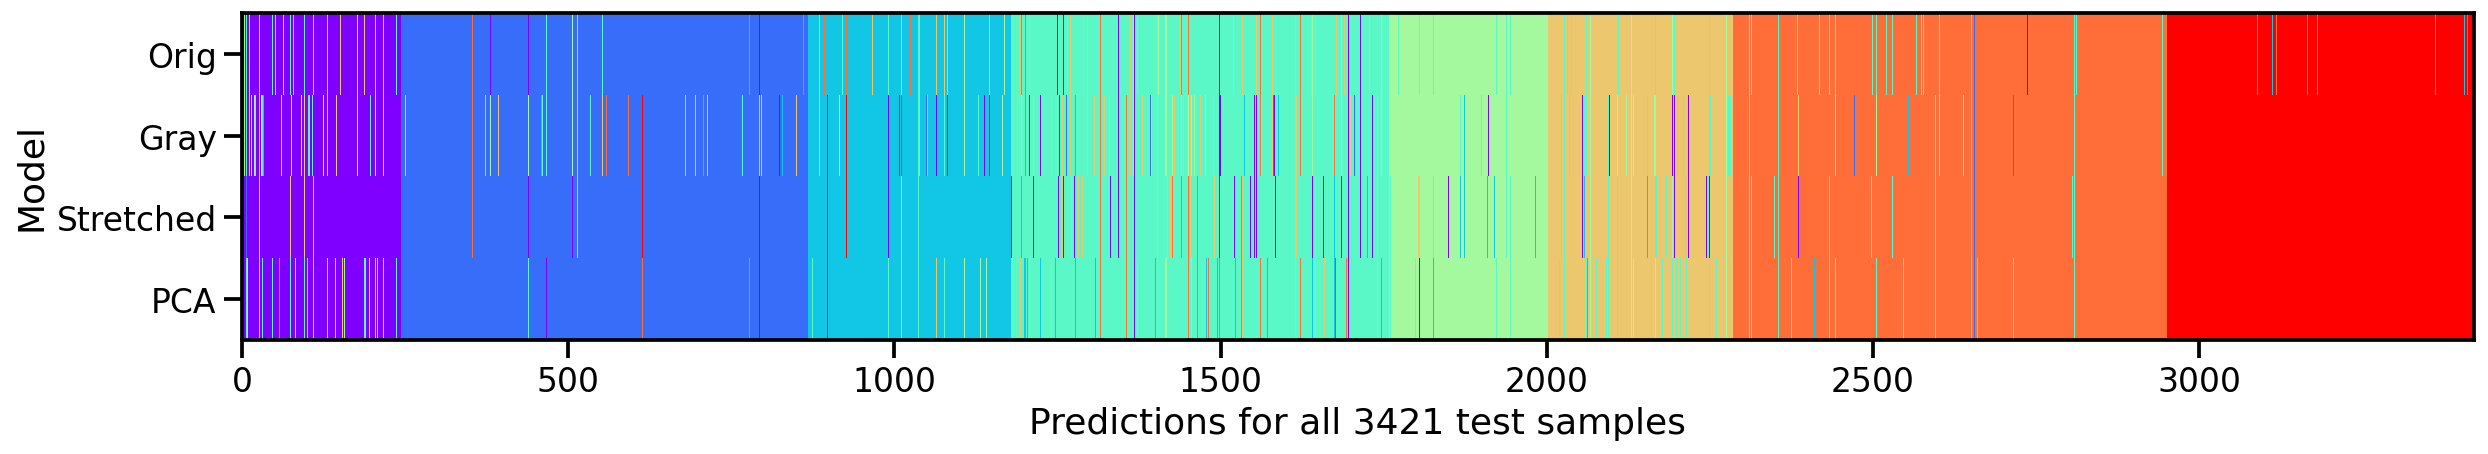

<IPython.core.display.Javascript object>

In [63]:
# Compute model specific predictions
y_pred_orig = model_orig.predict(X_te).argmax(axis=1)
y_pred_gray = model_gray.predict(X_te_gray).argmax(axis=1)
y_pred_stretch = model_stretch.predict(X_te_stretch).argmax(axis=1)
y_pred_pca = model_pca.predict(X_te_pca).argmax(axis=1)

# Aggregate all model predictions
target = y_te.ravel()
predictions = np.array([y_pred_orig, y_pred_gray, y_pred_stretch, y_pred_pca])[
    :, np.argsort(target)
]

# Plot model individual predictions
plt.figure(figsize=(20, 3))
plt.imshow(predictions, aspect="auto", interpolation="nearest", cmap="rainbow")
plt.xlabel(f"Predictions for all {predictions.shape[1]} test samples")
plt.ylabel("Model")
plt.yticks(ticks=range(4), labels=["Orig", "Gray", "Stretched", "PCA"]);

What we can see is that, except for the original dataset, none of the other models make mistakes in the 8th target class (here in red). So our manipulations seem to have been useful. And amongs the three approaches, the "realigned and stretched" dataset seems perform the best. To support this claim, let's take a look at the test accuracies of our four models.

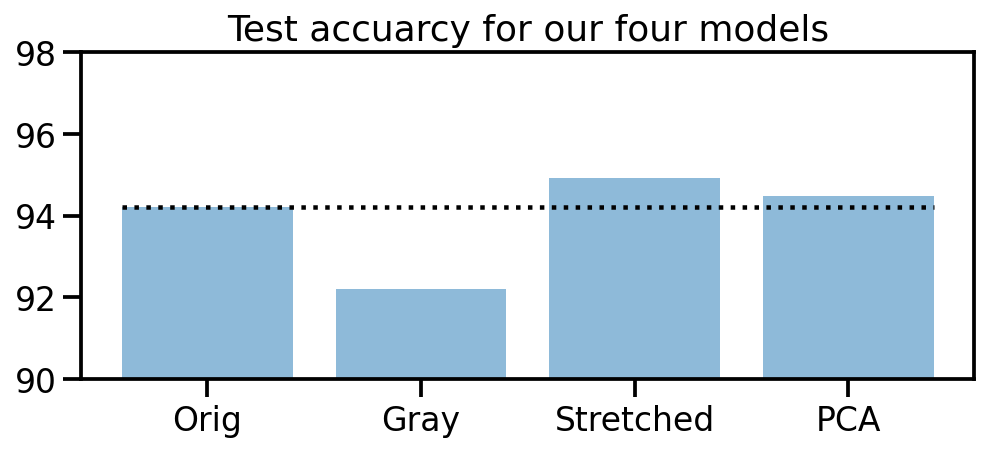

<IPython.core.display.Javascript object>

In [225]:
# Collect accuracies
accs_te = np.array([acc_orig_te, acc_gray_te, acc_stretch_te, acc_pca_te]) * 100

# Plot accuracies
plt.figure(figsize=(8, 3))

plt.title("Test accuracy for our four models")
plt.bar(["Orig", "Gray", "Stretched", "PCA"], accs_te, alpha=0.5)
plt.hlines(accs_te[0], -0.4, 3.4, colors="black", linestyles="dotted")
plt.ylim(90, 98);

# Model stacking

Seeing that our 4 models all perform slightly different, let's try to go one step further and train a "meta" model that uses the predictions of our 4 models as input.

In [209]:
# Compute prediction probabilities for all models and data sets
y_prob_tr_orig = model_orig.predict(X_tr)
y_prob_tr_gray = model_gray.predict(X_tr_gray)
y_prob_tr_stretch = model_stretch.predict(X_tr_stretch)
y_prob_tr_pca = model_pca.predict(X_tr_pca)

y_prob_va_orig = model_orig.predict(X_va)
y_prob_va_gray = model_gray.predict(X_va_gray)
y_prob_va_stretch = model_stretch.predict(X_va_stretch)
y_prob_va_pca = model_pca.predict(X_va_pca)

y_prob_te_orig = model_orig.predict(X_te)
y_prob_te_gray = model_gray.predict(X_te_gray)
y_prob_te_stretch = model_stretch.predict(X_te_stretch)
y_prob_te_pca = model_pca.predict(X_te_pca)

# Combine prediction probabilities into meta data sets
y_prob_tr = np.concatenate(
    [y_prob_tr_orig, y_prob_tr_gray, y_prob_tr_stretch, y_prob_tr_pca], axis=1)
y_prob_va = np.concatenate(
    [y_prob_va_orig, y_prob_va_gray, y_prob_va_stretch, y_prob_va_pca], axis=1)
y_prob_te = np.concatenate(
    [y_prob_te_orig, y_prob_te_gray, y_prob_te_stretch, y_prob_te_pca], axis=1)

# Combine training and validation dataset
y_prob_train = np.concatenate([y_prob_tr, y_prob_va], axis=0)
y_train = np.concatenate([y_tr, y_va], axis=0).ravel()

<IPython.core.display.Javascript object>

There are many different classification models to choose from, but to keep it short and compact, let's quickly train a multi-layer perceptron classifier and compare it's score to the other four models.

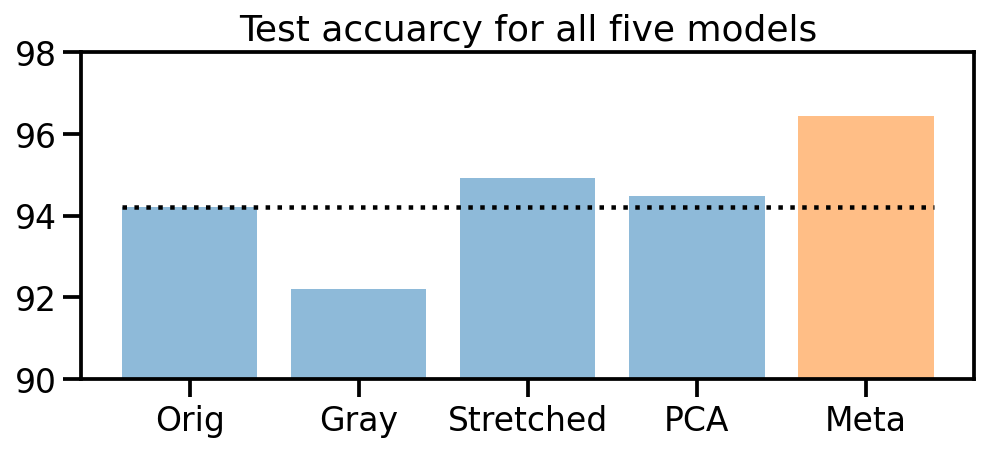

<IPython.core.display.Javascript object>

In [226]:
from sklearn.neural_network import MLPClassifier

# Create MLP classifier
clf = MLPClassifier(
    hidden_layer_sizes=(32, 16), activation="relu", solver="adam", alpha=0.42, batch_size=120,
    learning_rate="adaptive", learning_rate_init=0.001, max_iter=100, shuffle=True, random_state=24,
    early_stopping=True, validation_fraction=0.15)

# Train model
clf.fit(y_prob_train, y_train)

# Compute prediction accuracy of meta classifier
acc_meta_te = np.mean(clf.predict(y_prob_te) == y_te.ravel())

# Collect accuracies
accs_te = np.array([acc_orig_te, acc_gray_te, acc_stretch_te, acc_pca_te, 0]) * 100
accs_meta = np.array([0, 0, 0, 0, acc_meta_te]) * 100

# Plot accuracies
plt.figure(figsize=(8, 3))

plt.title("Test accuracy for all five models")
plt.bar(["Orig", "Gray", "Stretched", "PCA", "Meta"], accs_te, alpha=0.5)
plt.bar(["Orig", "Gray", "Stretched", "PCA", "Meta"], accs_meta, alpha=0.5)
plt.hlines(accs_te[0], -0.4, 4.4, colors="black", linestyles="dotted")
plt.ylim(90, 98);

Awesome! It worked! Training four different models on the original and three color transformed data sets, and then using these prediction probabilities to train a new meta classifier helped us to improve the initial prediction accuracy from 94% up to 96.4%!